In [1]:
import os
import sys
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression 
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
base_path = os.getcwd()
base_path = base_path.replace('notebooks', 'scripts') # note: if you have notebooks twice in your base_path, this won't work
sys.path.insert(1, base_path)

from helpers import *
from utils import remove_top_right_frame, jitter_scatterplot

In [3]:
# Make paths
main_dir = r'' # EDIT the path !!!!!!!
print('Main working directory:', main_dir)
figure_path = os.path.join(main_dir, 'Figures')
os.makedirs(figure_path, exist_ok=True)
data_path = os.path.join(main_dir, '') #if your folder is organized differently, just specify the full path to the .mat file

fname = 'data_bio482.pkl'
data_df = pd.read_pickle(os.path.join(data_path, fname))

Main working directory: 


In [4]:
sweep_type = 'active touch'

pre_window = 0.1 # time before touch onset (s)
post_window = 0.3 # time after touch onset (s)
min_event_dur = 0 # minimal duration of active touch episode to be considered
min_iti = 0.2 # minimal intertrial interval (ITI) between 2 consecutive touch episode (s)
min_number_trials = 2 # minimal number of trial
bin_size = 0.01 # bin size for psth (s)
epoch_bounds = {'pre':[-0.05, 0],
                  'post':[0,0.1]}  # time boundaries to compute changes in whisker protraction (WP), or Vm

In [5]:
data_df_subset = data_df[data_df['Sweep_Type']==sweep_type] 

In [6]:
all_cells = np.unique(data_df_subset.Cell_ID)
print('Number of cells:', len(all_cells))

Number of cells: 134


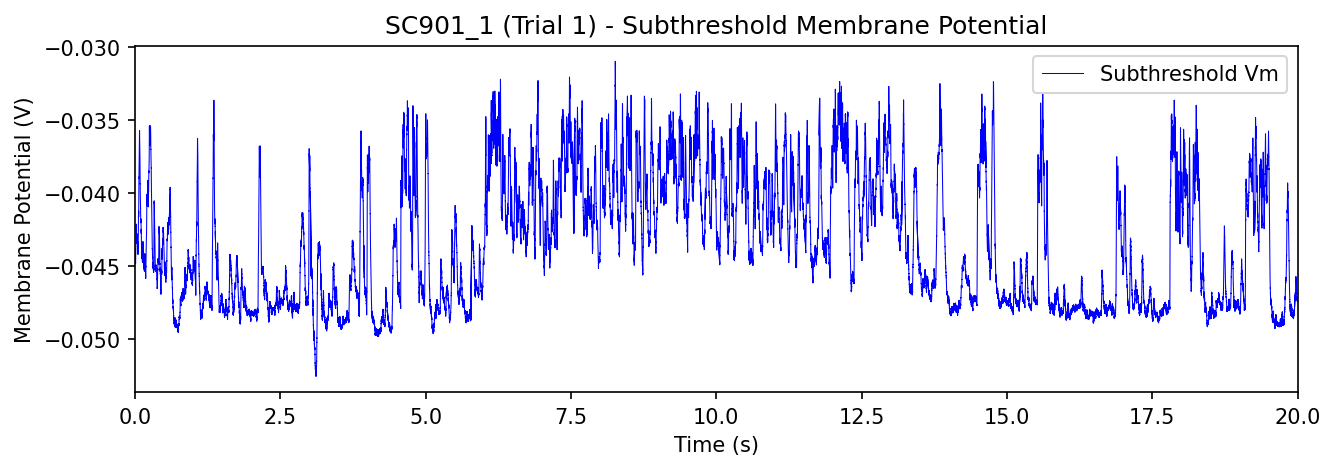

In [11]:
cell_list = sorted(np.unique(data_df_subset.Cell_ID), reverse=True) #NOTE: DO NOT START WITH AC32 bc. no AP and undefined ap_params content

cell_data = data_df_subset.iloc[0]
cell_df = data_df_subset[data_df_subset.Cell_ID==cell_data['Cell_ID']]
# Get sweeps/trials recorded for that cell, that we are going to iterate over
trial_list = cell_df.Sweep_Counter.values
trial=trial_list[0]
# Get current trial data
cell_trial_df = cell_df[cell_df.Sweep_Counter==trial]

# Get the sampling rate and membrane potential (and derivative) from that sweep
        
sr_vm = cell_trial_df['Sweep_MembranePotential_SamplingRate'].values[0] #[0] to get the content of the array
membrane_potential = cell_trial_df['Sweep_MembranePotential'].values[0]
ap_vm_deriv_thresh = cell_df['Cell_APThreshold_Slope'].values[0]
        
# Get and update recording duration for that cell by adding trial duration
trial_rec_duration = len(membrane_potential)/sr_vm
#ap_params = None
ap_params = Function_Detect_APs(membrane_potential, sr_vm, ap_vm_deriv_thresh) 
# Get current trial data
cell_trial_df = cell_df[cell_df.Sweep_Counter==trial]

# Extract action potential parameters
ap_peak_times = ap_params[:, 2]  # Assuming the third column contains AP peak times
ap_thresh_times = ap_params[:, 0]  # Assuming the first column contains AP threshold times

# Process the membrane potential to remove APs
vm_subthreshold = Function_CutAPs(membrane_potential, sr_vm, ap_peak_times, ap_thresh_times)

# Time array for plotting
time = np.arange(len(vm_subthreshold)) / sr_vm

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(10, 3), dpi=150)
ax.set_title(f'{cell_data["Cell_ID"]} (Trial {int(trial)}) - Subthreshold Membrane Potential')
ax.plot(time, vm_subthreshold, lw=0.5, color='blue', label='Subthreshold Vm')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Membrane Potential (V)')
ax.legend()
plt.xlim([0, len(vm_subthreshold) / sr_vm])  # Adjust this range as needed

# Save the plot if needed
# plt.savefig('path_to_save_figure.png', dpi=150, format='png', bbox_inches='tight')

plt.show()

In [12]:
# Assuming cell_trial_df contains the current trial data
active_touch_times = cell_df['Sweep_ActiveContactTimes'].values[0]

# Process the membrane potential to remove APs
vm_subthreshold = Function_CutAPs(membrane_potential, sr_vm, ap_peak_times, ap_thresh_times)

# Time array for indexing
time_array = np.arange(len(vm_subthreshold)) / sr_vm

# Initialize a list to store min and max Vm for each active touch interval
min_max_vm_values = []

# Iterate over each active touch interval
for start, end in active_touch_times:
    # Convert the start and end time of the active touch to indices
    start_index = np.searchsorted(time_array, start)
    end_index = np.searchsorted(time_array, end+0.05)

    # Extract the Vm segment for the current interval
    vm_segment = vm_subthreshold[start_index:end_index]

    # Calculate the minimum and maximum Vm for the segment
    min_vm = np.min(vm_segment)
    max_vm = np.max(vm_segment)

    # Store the results
    min_max_vm_values.append((min_vm, max_vm))

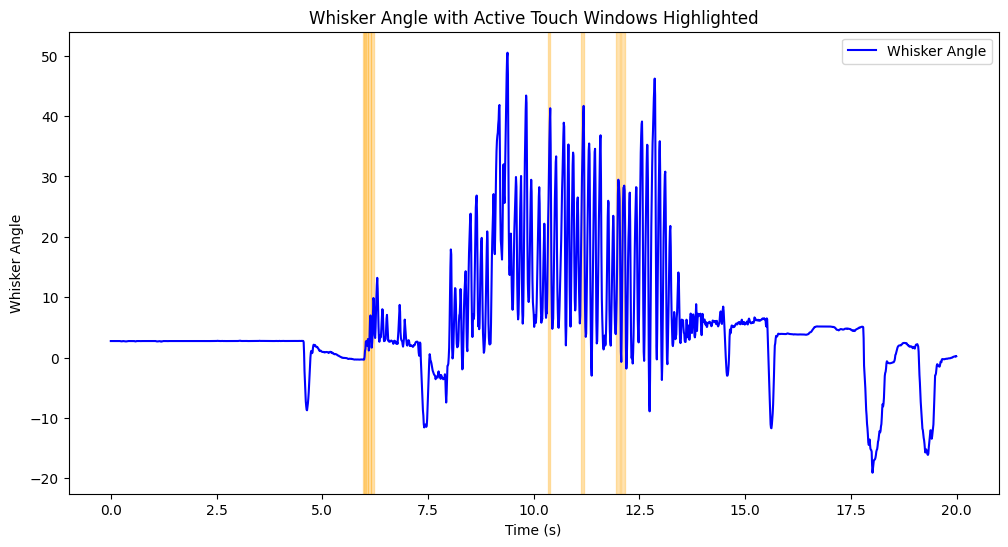

In [13]:
import matplotlib.pyplot as plt
import numpy as np
cell_data = data_df_subset.iloc[0]
# Assuming cell_data, whisker_angle, and active_touch_times are defined as before
whisker_angle = cell_df['Sweep_WhiskerAngle'].values[0]
sampling_rate = cell_data['Sweep_WhiskerAngle_SamplingRate']  # This should be a scalar value
time_points = np.arange(len(whisker_angle)) / sampling_rate

# Plotting the whisker angle
plt.figure(figsize=(12, 6))
plt.plot(time_points, whisker_angle, label='Whisker Angle', color='blue')

# Highlighting the active touch windows
for start_time, end_time in active_touch_times:
    plt.axvspan(start_time - 0.05, end_time, color='orange', alpha=0.3)

plt.xlabel('Time (s)')
plt.ylabel('Whisker Angle')
plt.title('Whisker Angle with Active Touch Windows Highlighted')
plt.legend()
plt.show()


In [16]:
# Extract the event times (active touch times) from cell_df
event_times = cell_df['Sweep_ActiveContactTimes'].values[0]  # Assuming this is a 2D array with [start, end] pairs

# Initialize a list to store the intercontact intervals
iti_dur_tot = []

# Loop through the event times and calculate the intercontact intervals
for event in range(1, len(event_times)):
    # Calculate the duration between the end of the previous event and the start of the current event
    iti_dur = event_times[event][0] - event_times[event - 1][1]
    
    # Check if the duration is positive (meaning the next event starts after the previous event ends)
    if iti_dur > 0:
        iti_dur_tot.append(iti_dur)
    else:
        # If the duration is not positive, it indicates overlapping or immediate successive events
        # Handle this case as needed, for example by appending a zero or continuing without appending
        iti_dur_tot.append(0)  # Or simply continue without appending anything

# iti_dur_tot now contains the intercontact intervals


In [17]:
iti_dur_tot

[0.005999999999999339,
 0.03399999999999981,
 0.0600000000000005,
 4.167999999999999,
 0.7840000000000007,
 0.8140000000000001,
 0.08800000000000097]

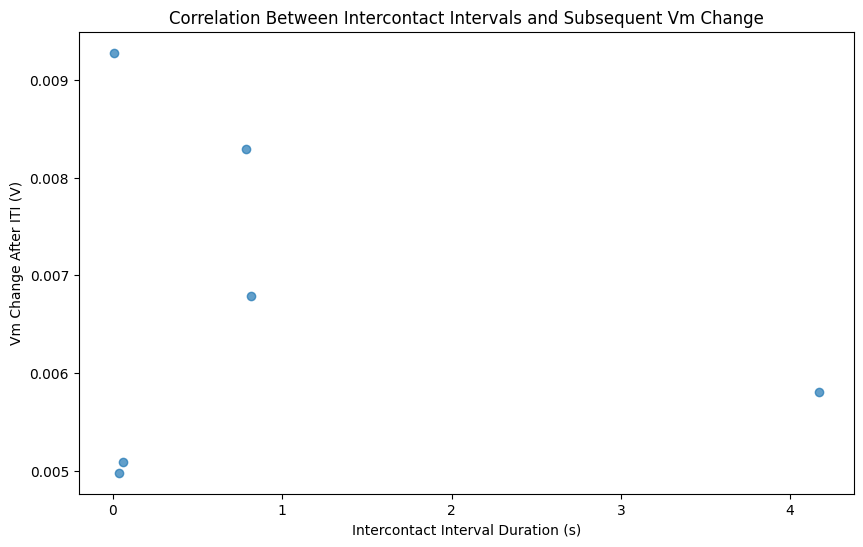

In [22]:
import matplotlib.pyplot as plt

# Assuming that iti_dur_tot and min_max_vm_values are calculated as before

# Initialize a list to store the change in Vm that immediately follows each ITI
post_iti_vm_change = []

# Since there is no ITI before the first active touch and no Vm change after the last one,
# there will be one less vm change than there are ITIs. We will correlate starting from the
# first ITI to the second-to-last Vm change.
for i in range(len(iti_dur_tot) - 1):
    # The change in Vm is the max - min Vm in the active touch interval that follows the ITI
    vm_change = min_max_vm_values[i+1][1] - min_max_vm_values[i+1][0]
    post_iti_vm_change.append(vm_change)

# Now correlate iti_dur_tot with post_iti_vm_change
# Make sure to exclude the last ITI since there is no following Vm change to correlate with it
plt.figure(figsize=(10, 6))
plt.scatter(iti_dur_tot[:-1], post_iti_vm_change, alpha=0.7)
plt.xlabel('Intercontact Interval Duration (s)')
plt.ylabel('Vm Change After ITI (V)')
plt.title('Correlation Between Intercontact Intervals and Subsequent Vm Change')
plt.show()


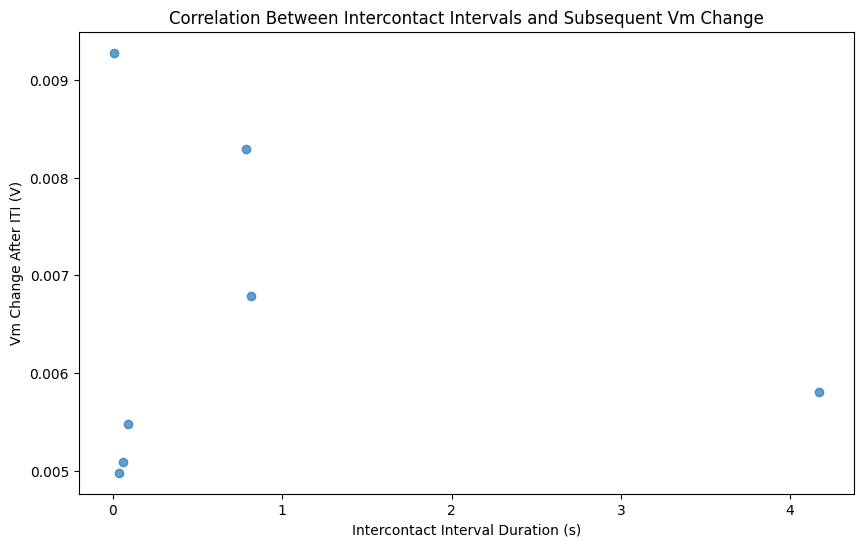

In [24]:
import matplotlib.pyplot as plt

# Assuming that iti_dur_tot and min_max_vm_values are calculated as before

# Initialize a list to store the change in Vm that immediately follows each ITI
post_iti_vm_change = []

# Iterate through the ITI durations, excluding the last ITI if there's no subsequent Vm change
for i in range(len(iti_dur_tot)):
    # The change in Vm is the max - min Vm in the active touch interval that follows the ITI
    # Ensure we do not go out of bounds
    if i < len(min_max_vm_values) - 1:
        vm_change = min_max_vm_values[i+1][1] - min_max_vm_values[i+1][0]
        post_iti_vm_change.append(vm_change)
    else:
        # Handle the last ITI if there is no Vm change after it
        post_iti_vm_change.append(0)  # Or handle accordingly if you have data for the last interval

# Now correlate iti_dur_tot with post_iti_vm_change
plt.figure(figsize=(10, 6))
plt.scatter(iti_dur_tot, post_iti_vm_change, alpha=0.7)
plt.xlabel('Intercontact Interval Duration (s)')
plt.ylabel('Vm Change After ITI (V)')
plt.title('Correlation Between Intercontact Intervals and Subsequent Vm Change')
plt.show()


The Pearson Correlation Coefficient is: 0.03211102417527655 and the p-value is 0.5770409247678558


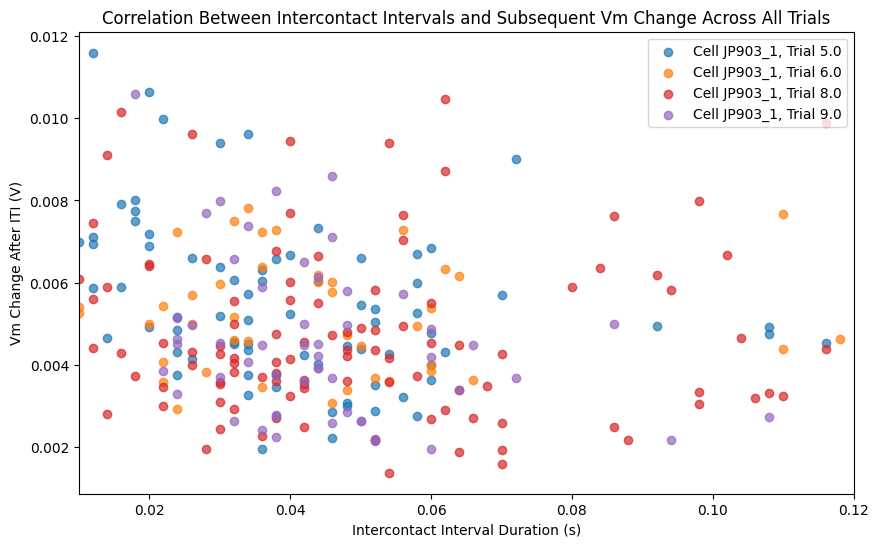

The Pearson Correlation Coefficient is: -0.18668742876106065 and the p-value is 0.15322113412024457


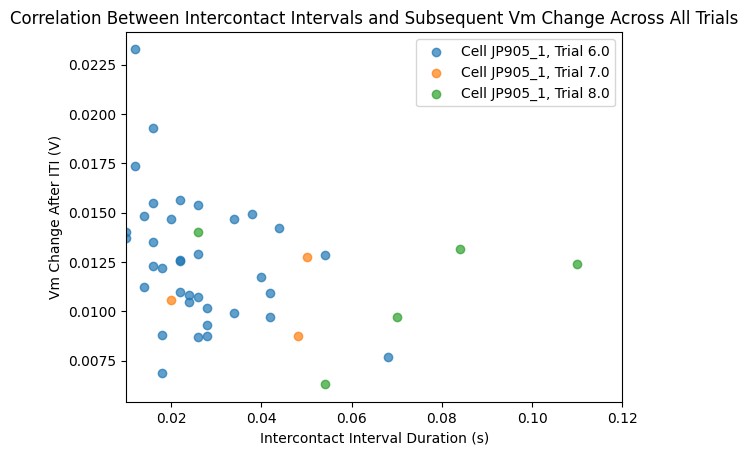

The Pearson Correlation Coefficient is: 0.28516737178592355 and the p-value is 1.668265984407452e-06


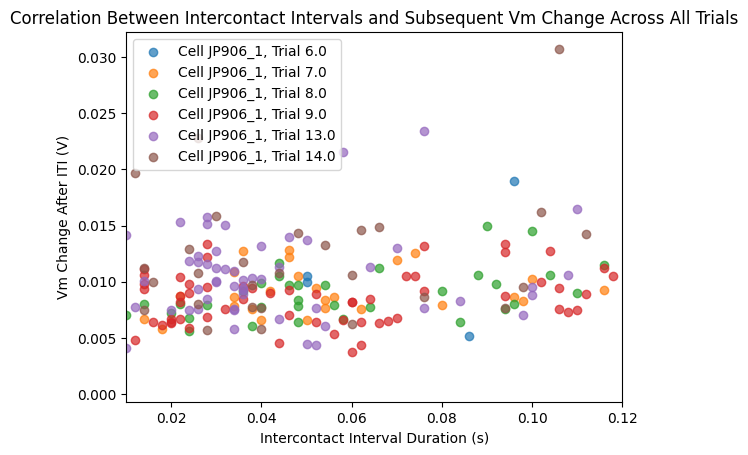

The Pearson Correlation Coefficient is: -0.1793311318160302 and the p-value is 0.041198918766095514


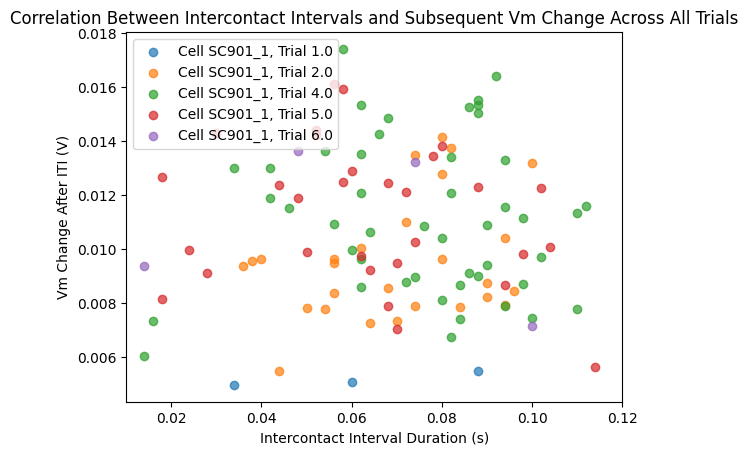

The Pearson Correlation Coefficient is: 0.31446358059151025 and the p-value is 0.12577904625131633


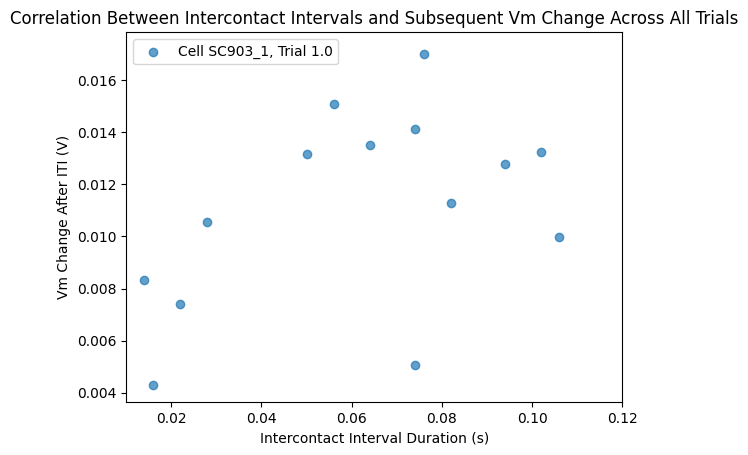

The Pearson Correlation Coefficient is: 0.03225365621331399 and the p-value is 0.6744653101991438


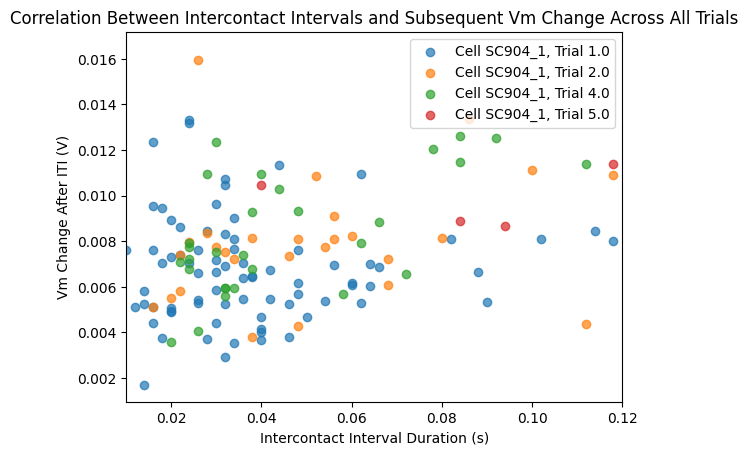

The Pearson Correlation Coefficient is: 0.4277997675380223 and the p-value is 0.00019819822874380186


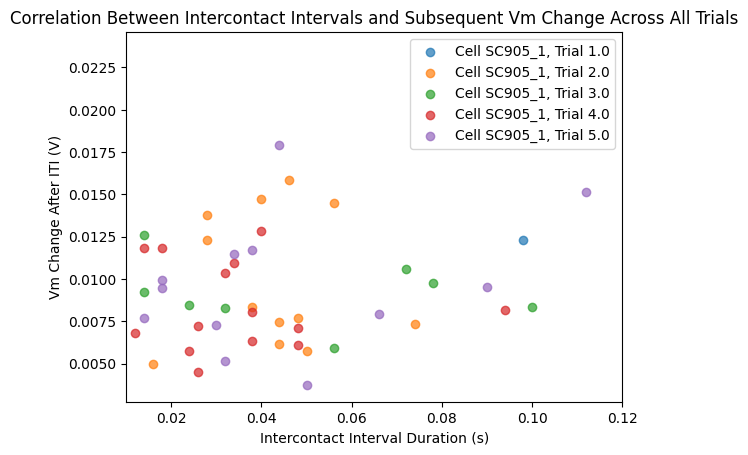

The Pearson Correlation Coefficient is: 0.005644287636259529 and the p-value is 0.9518392213905514


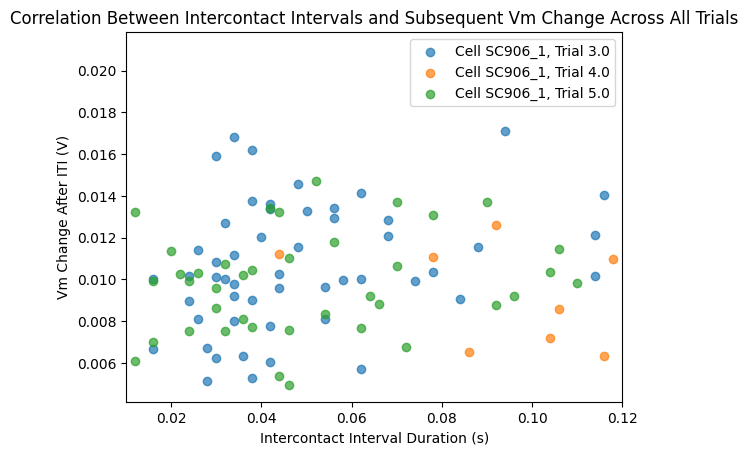

The Pearson Correlation Coefficient is: 0.11806082658054412 and the p-value is 0.2570901445446827


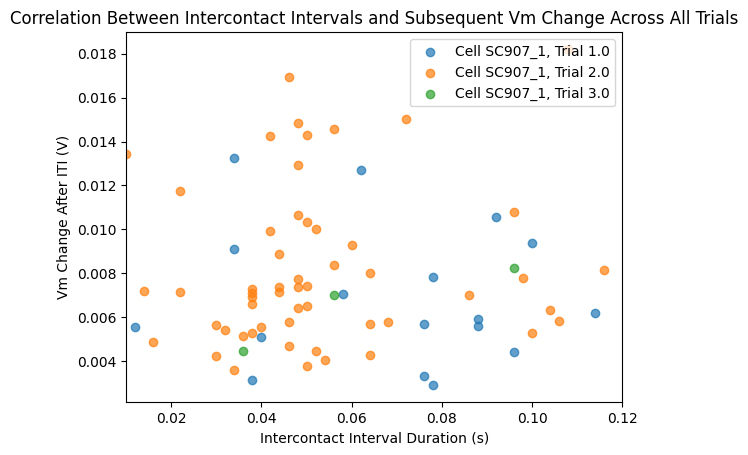

The Pearson Correlation Coefficient is: 0.299540923412366 and the p-value is 2.317220909727057e-05


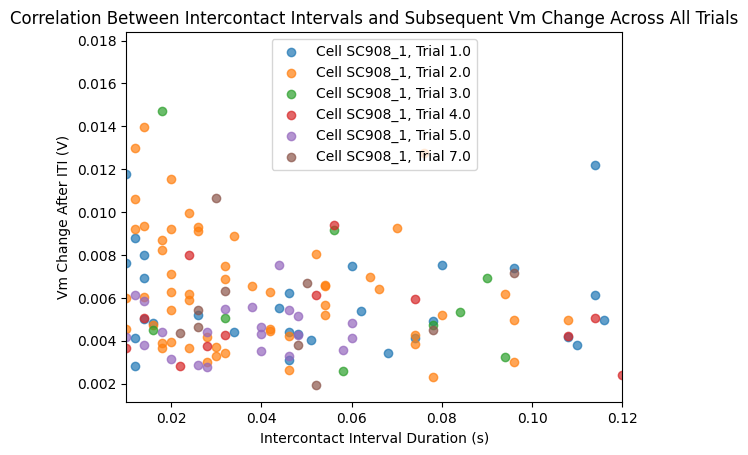

The Pearson Correlation Coefficient is: 0.17699605727717024 and the p-value is 0.0695180930107513


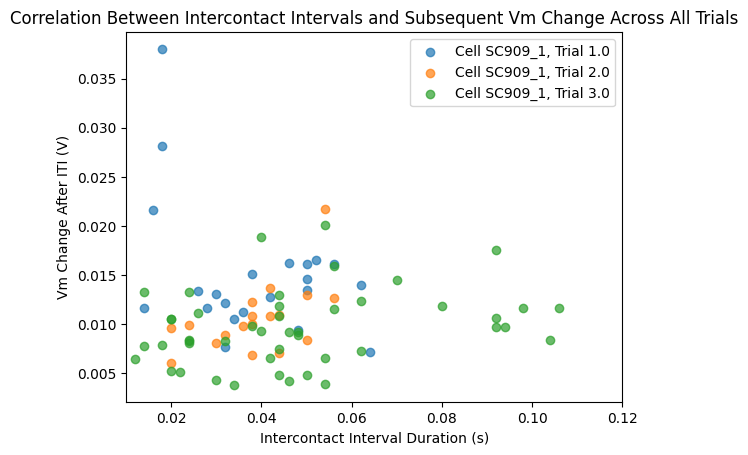

The Pearson Correlation Coefficient is: 0.29081062366254967 and the p-value is 0.0002305644594291381


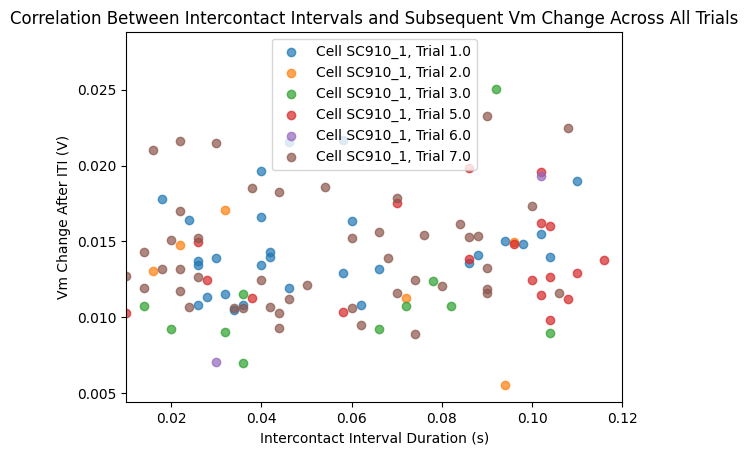

The Pearson Correlation Coefficient is: 0.15447060464593107 and the p-value is 0.32869213390367147


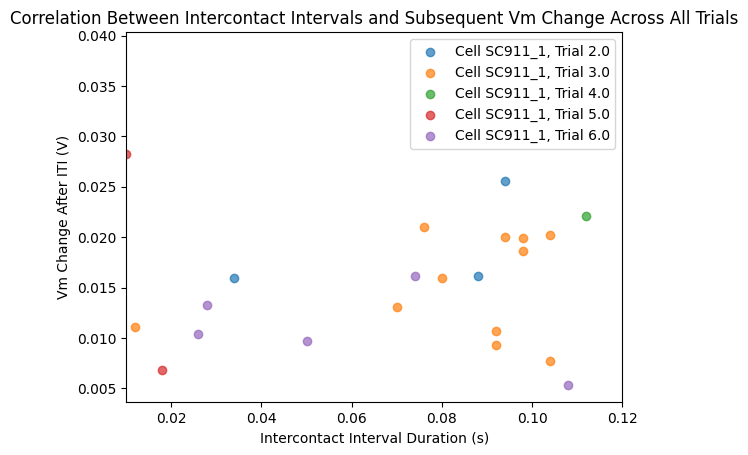

The Pearson Correlation Coefficient is: 0.08691735715081933 and the p-value is 0.25690135746257087


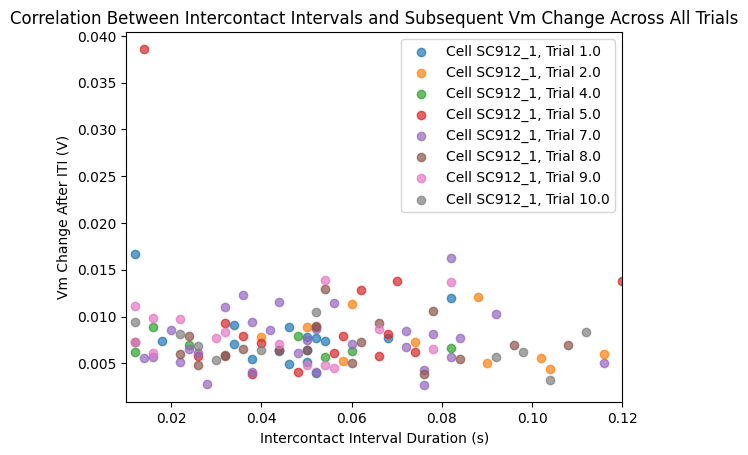

The Pearson Correlation Coefficient is: -0.026631658042196974 and the p-value is 0.8756691871496873


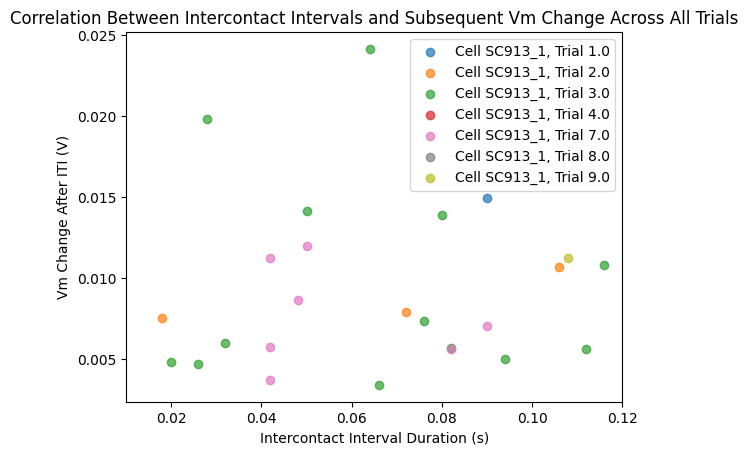

The Pearson Correlation Coefficient is: -0.02271755595052567 and the p-value is 0.8878834505198416


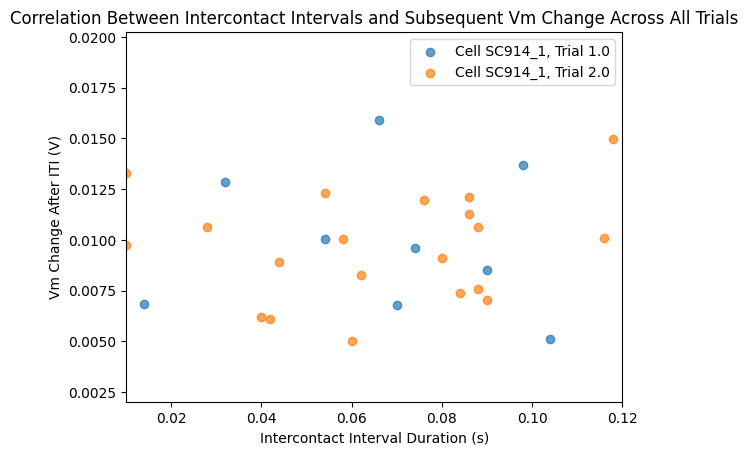

The Pearson Correlation Coefficient is: 0.03829902435775603 and the p-value is 0.8622616754253355


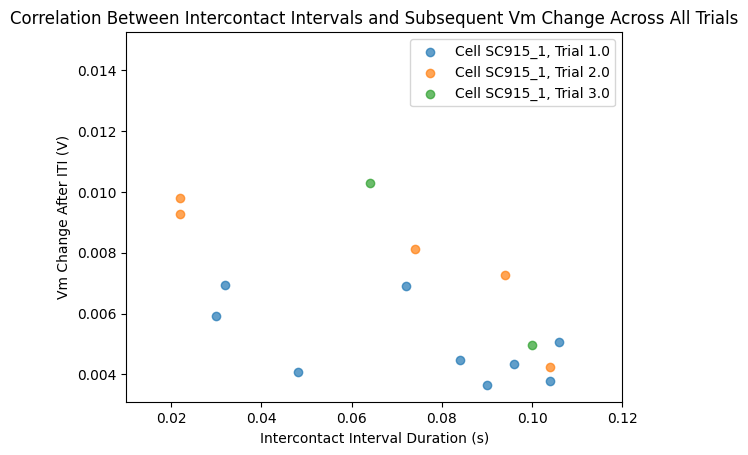

The Pearson Correlation Coefficient is: 0.06795061114299208 and the p-value is 0.44418605070564326


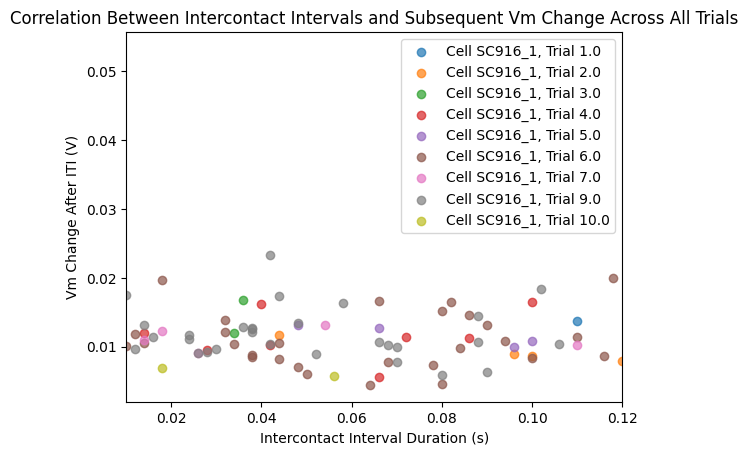

The Pearson Correlation Coefficient is: 0.43227378558599133 and the p-value is 7.78865134729465e-08


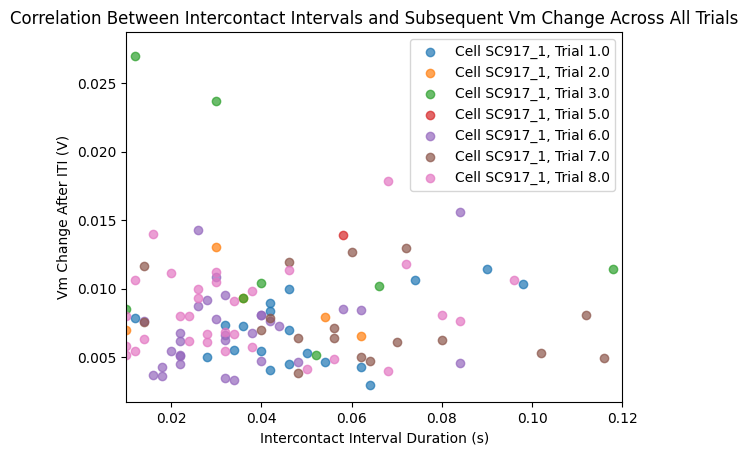

The Pearson Correlation Coefficient is: 0.13958831969380703 and the p-value is 0.02827683479386163


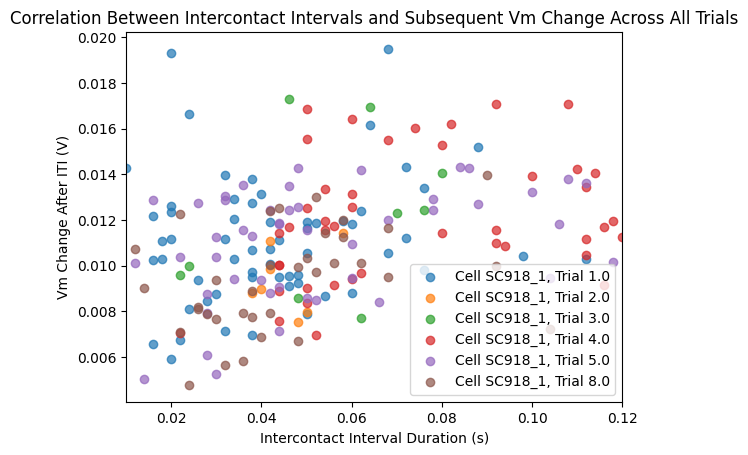

The Pearson Correlation Coefficient is: 0.10195854787133284 and the p-value is 0.3712598652509076


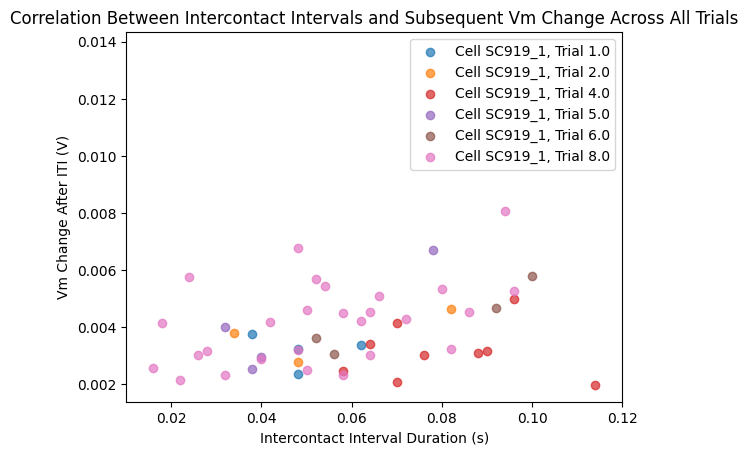

The Pearson Correlation Coefficient is: -0.020549993464863258 and the p-value is 0.6904412249396763


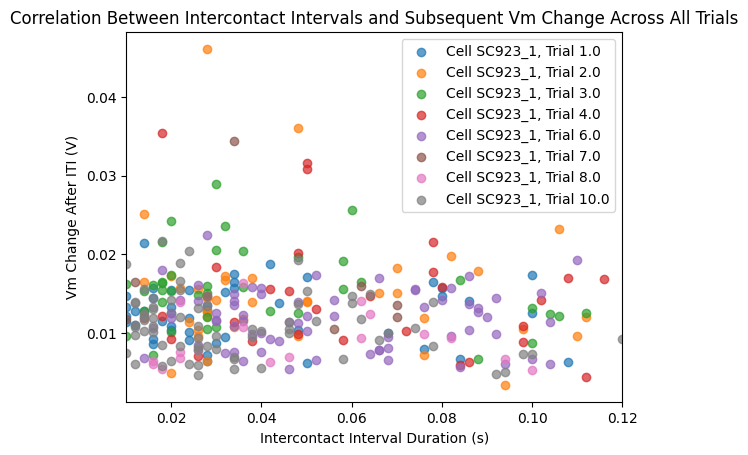

The Pearson Correlation Coefficient is: 0.29668390182246496 and the p-value is 0.0014183498729693775


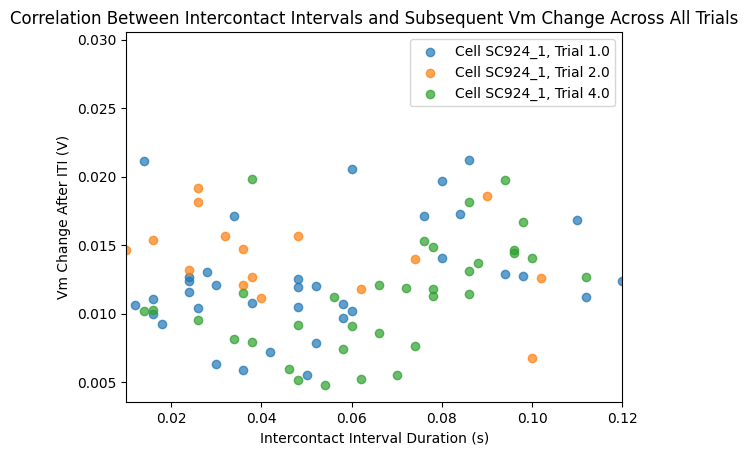

The Pearson Correlation Coefficient is: 0.32999002085666895 and the p-value is 2.463073820074227e-09


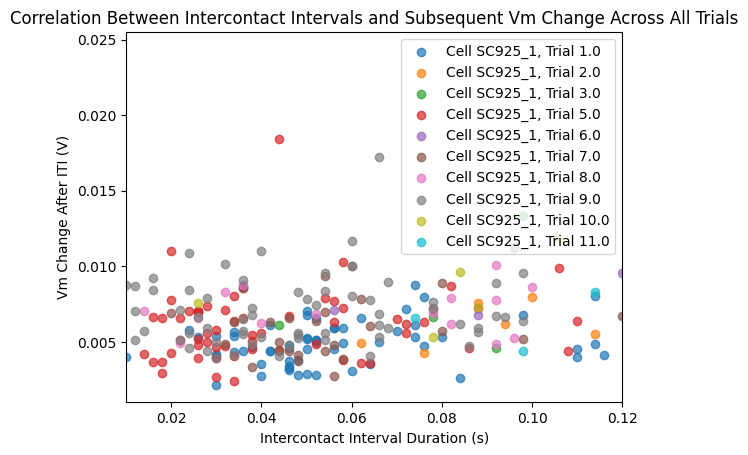

The Pearson Correlation Coefficient is: 0.12581108753743486 and the p-value is 0.10521727200970024


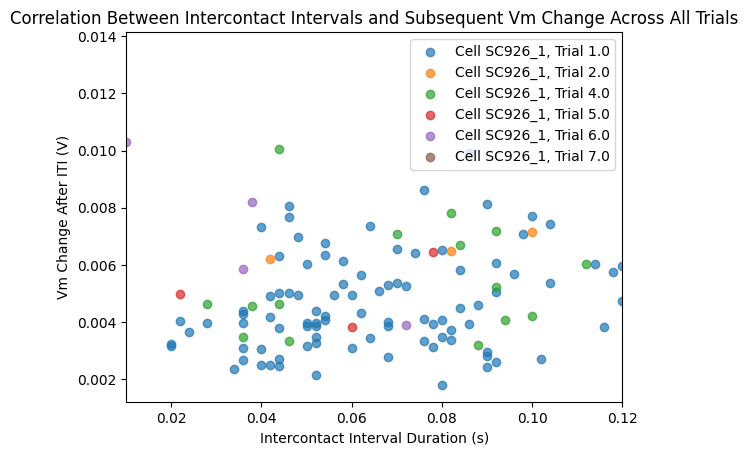

The Pearson Correlation Coefficient is: 0.30765600387947817 and the p-value is 0.05674100496692934


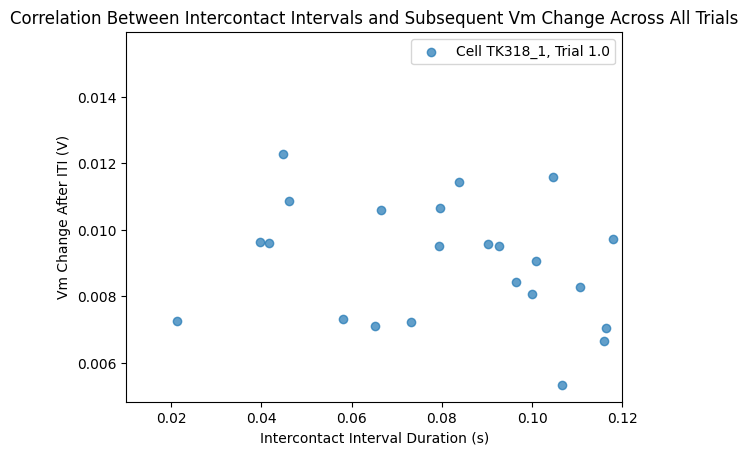

The Pearson Correlation Coefficient is: 0.21725532252557211 and the p-value is 0.6052827975658416


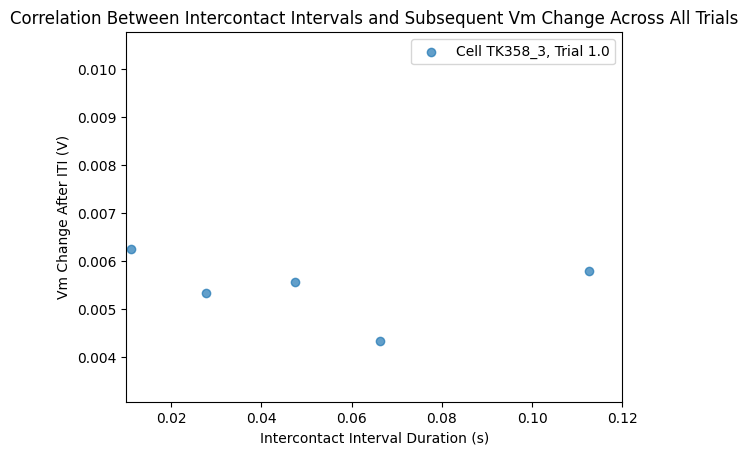

The Pearson Correlation Coefficient is: 0.005036498802391896 and the p-value is 0.9492822261918417


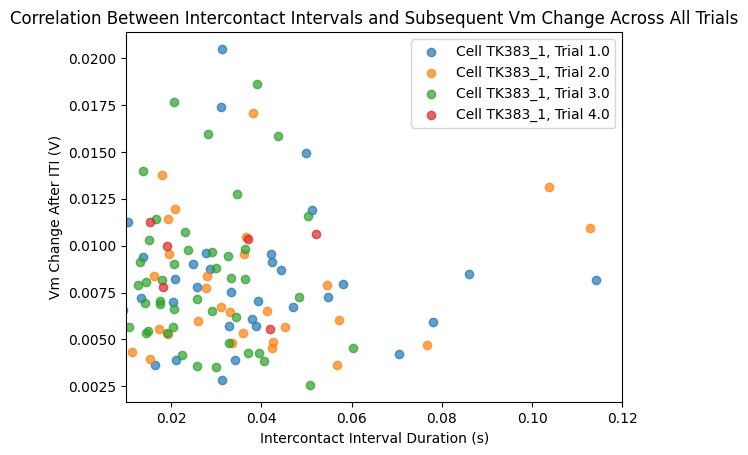

The Pearson Correlation Coefficient is: 0.408295058783173 and the p-value is 0.0004082865547748829


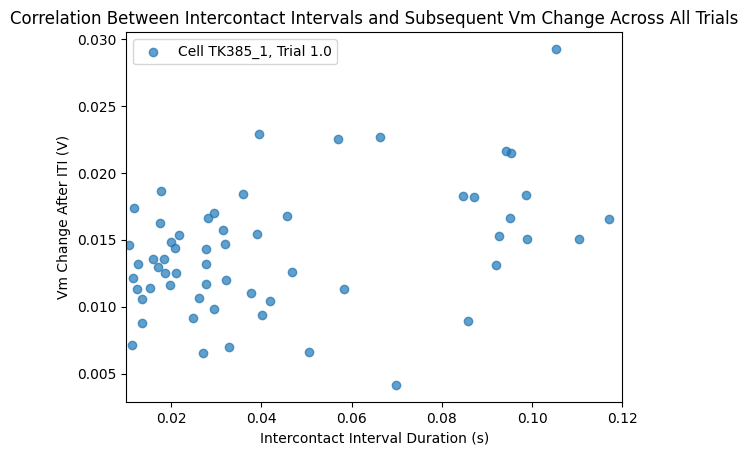

The Pearson Correlation Coefficient is: -0.05579060665288928 and the p-value is 0.41242063583336735


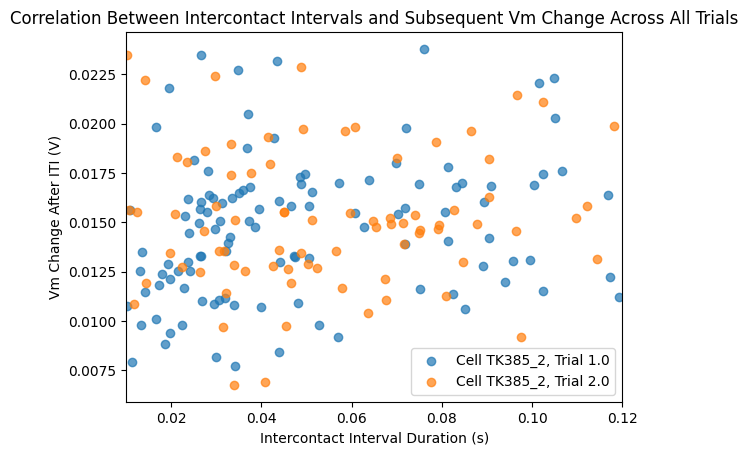

The Pearson Correlation Coefficient is: 0.051383637833011885 and the p-value is 0.7042466104936334


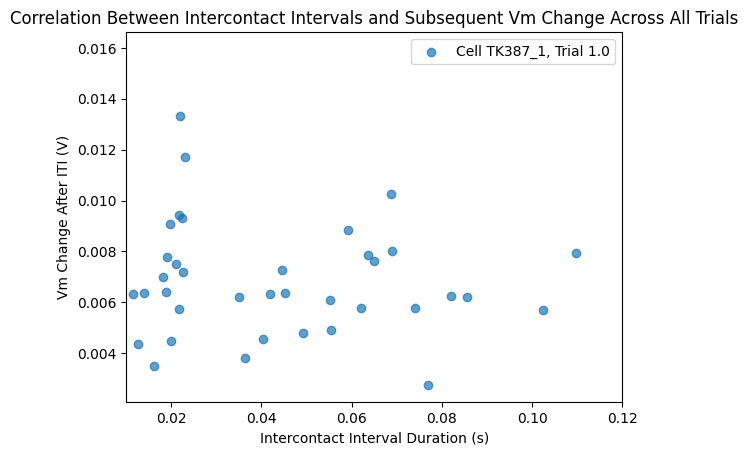

The Pearson Correlation Coefficient is: -0.26203122048760047 and the p-value is 0.10239298478483277


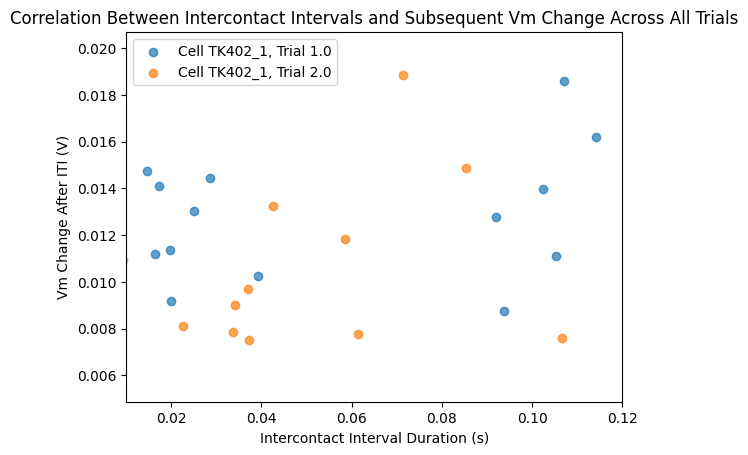

The Pearson Correlation Coefficient is: -0.1429331891855946 and the p-value is 0.3919568451694466


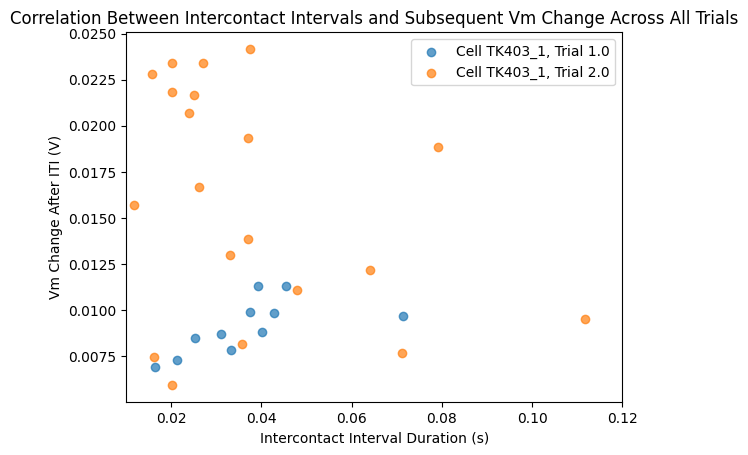

The Pearson Correlation Coefficient is: -0.23602512154488844 and the p-value is 0.029656434093189257


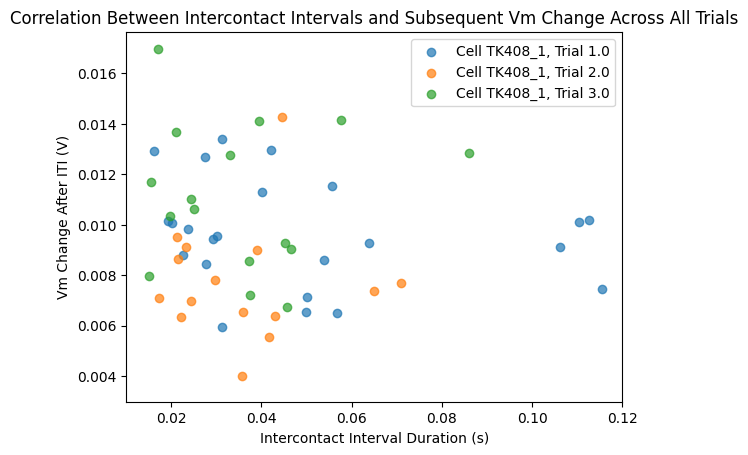

The Pearson Correlation Coefficient is: 0.09012596567625768 and the p-value is 0.7055245117205509


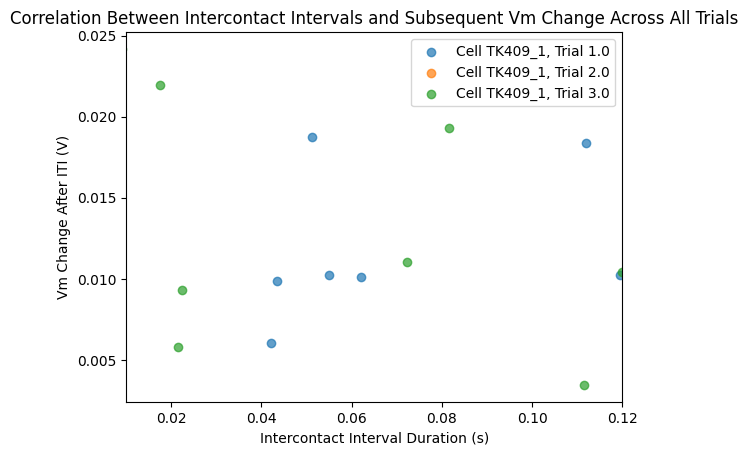

The Pearson Correlation Coefficient is: 0.17912015885127228 and the p-value is 0.40233087330886125


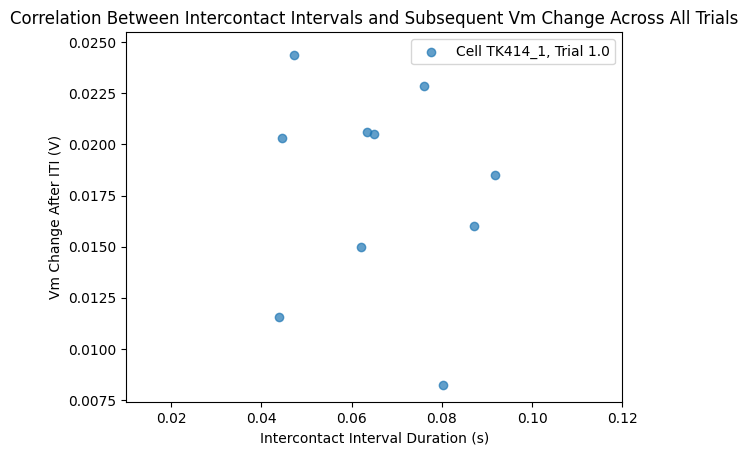

The Pearson Correlation Coefficient is: -0.0774948424193545 and the p-value is 0.40626466051616106


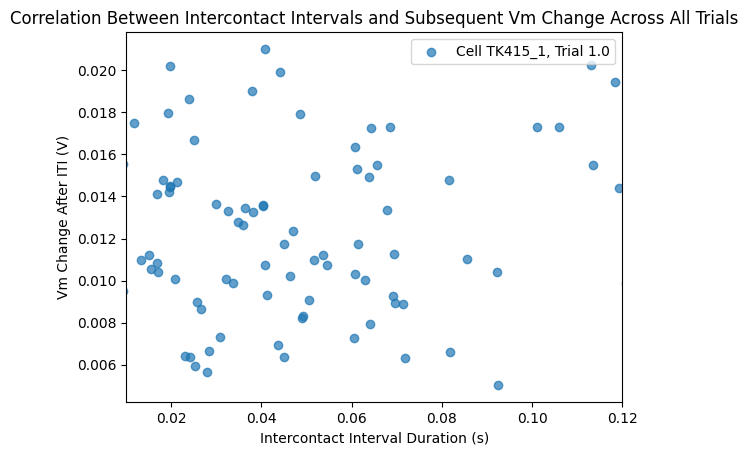

The Pearson Correlation Coefficient is: 0.0630755253196174 and the p-value is 0.5267565589229756


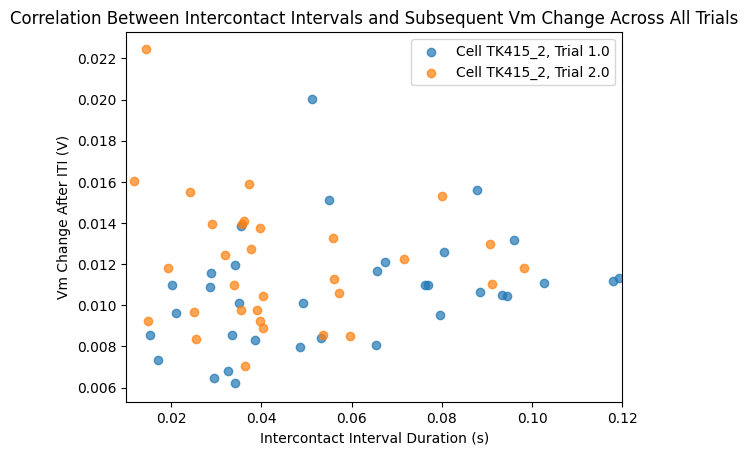

The Pearson Correlation Coefficient is: 0.01471397394705299 and the p-value is 0.9272489671434568


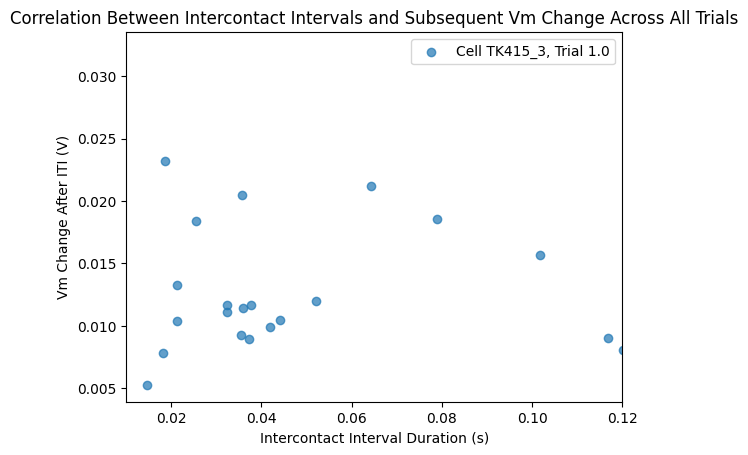

The Pearson Correlation Coefficient is: 0.03177941275707864 and the p-value is 0.7984953617133853


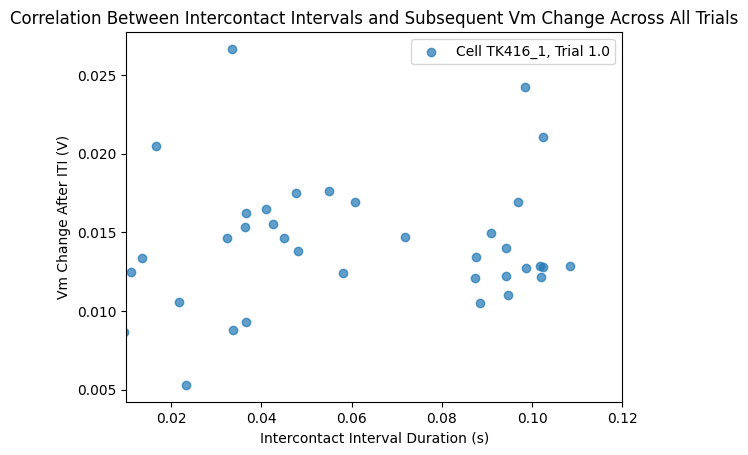

The Pearson Correlation Coefficient is: 0.38913208936505955 and the p-value is 0.0008704691646595965


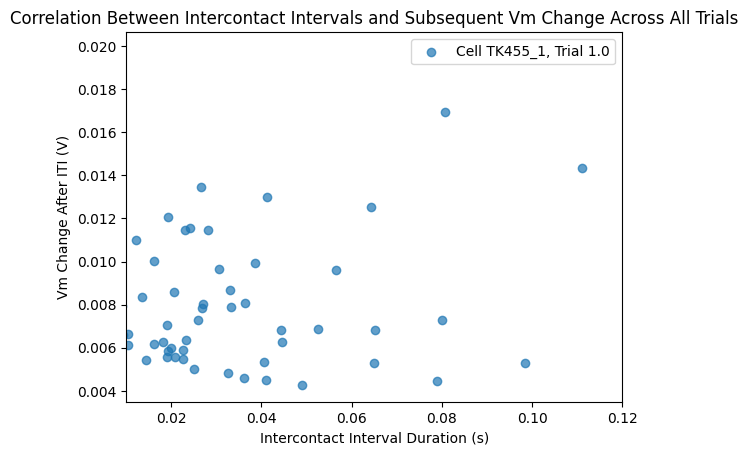

The Pearson Correlation Coefficient is: 0.14922717184550158 and the p-value is 0.05965290700737225


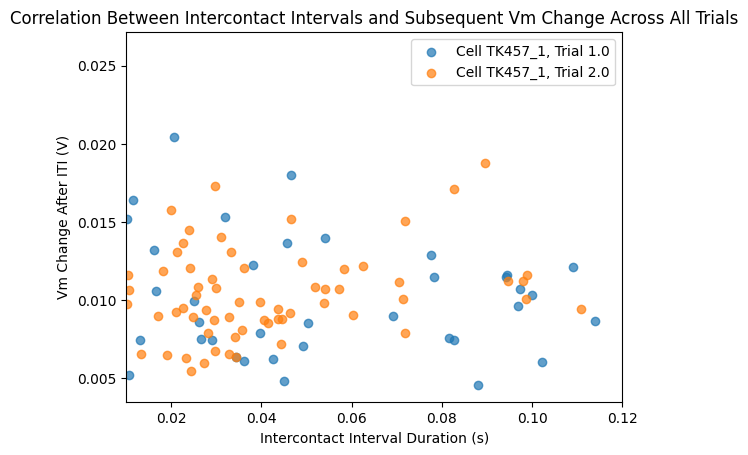

The Pearson Correlation Coefficient is: 0.42091992338429773 and the p-value is 0.0005334073615340194


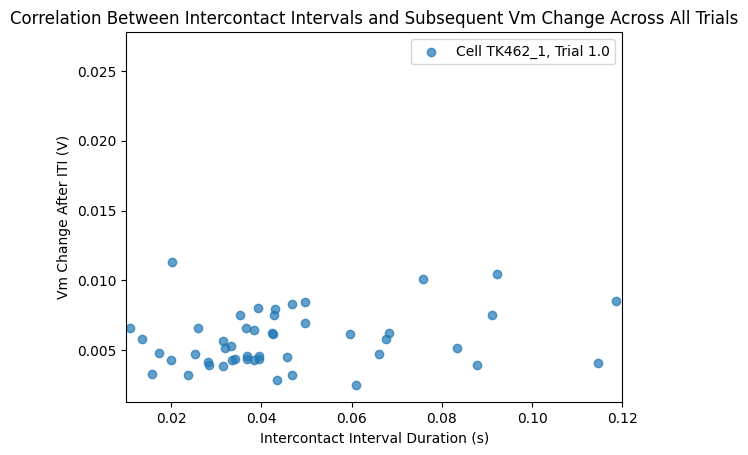

The Pearson Correlation Coefficient is: 0.373402115287964 and the p-value is 0.01486239438429074


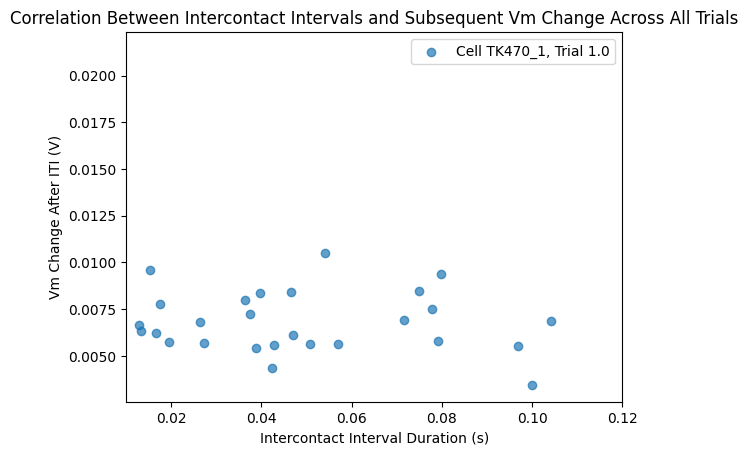

The Pearson Correlation Coefficient is: 0.2021091138217952 and the p-value is 0.0032633438426058563


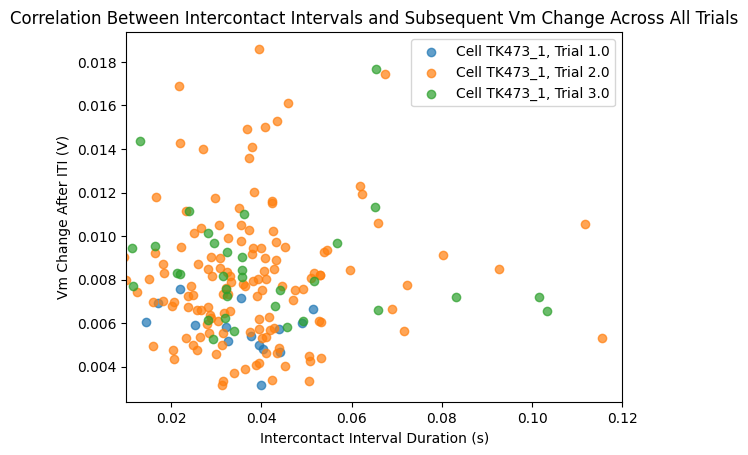

The Pearson Correlation Coefficient is: -0.10725099229913997 and the p-value is 0.6020273637692994


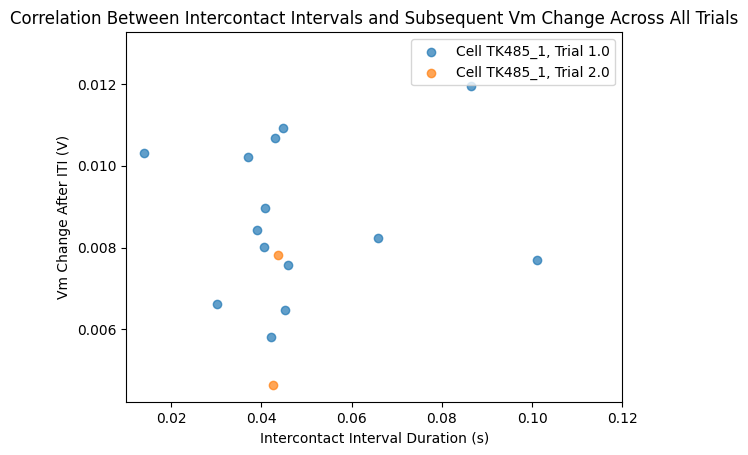

The Pearson Correlation Coefficient is: 0.04885393093533601 and the p-value is 0.6570372920239198


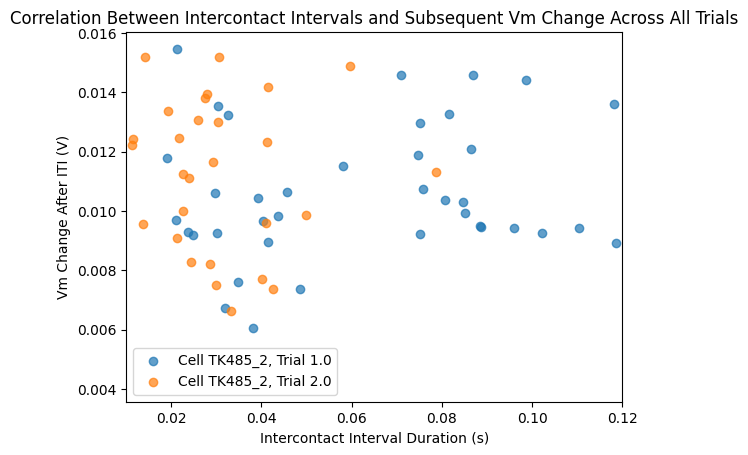

The Pearson Correlation Coefficient is: 0.007160453993910742 and the p-value is 0.955951455894289


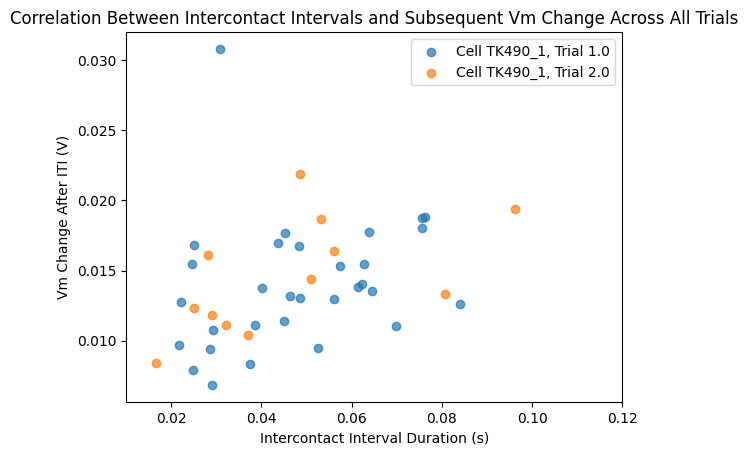

The Pearson Correlation Coefficient is: -0.13152674858531466 and the p-value is 0.33847096044753017


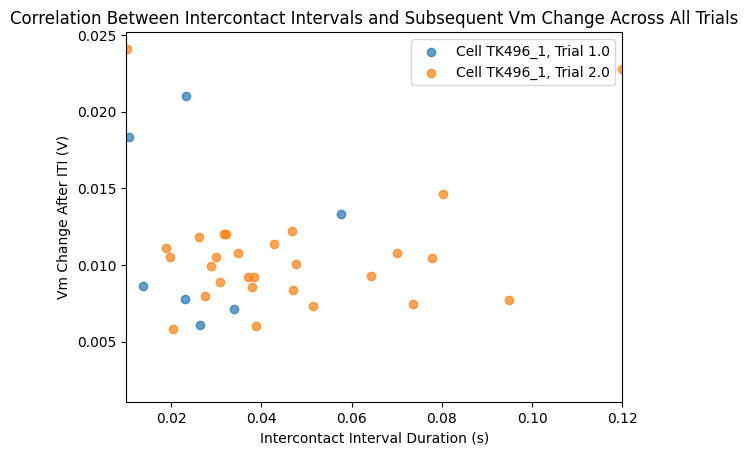

The Pearson Correlation Coefficient is: -0.015802638862650955 and the p-value is 0.9079726615575568


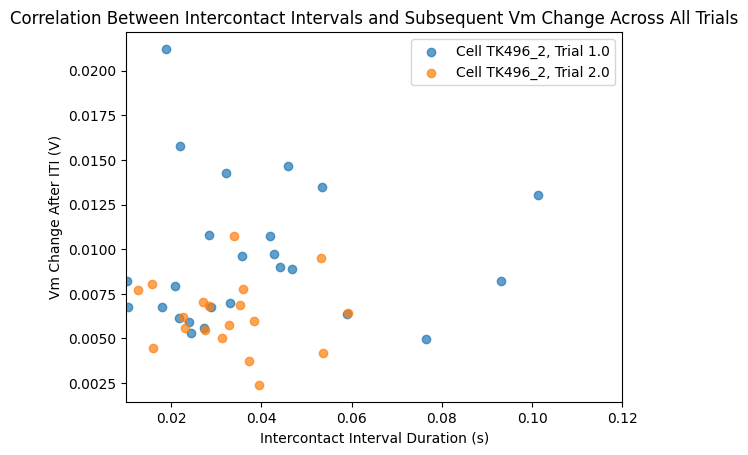

The Pearson Correlation Coefficient is: 0.3767279240827951 and the p-value is 0.030693764895360104


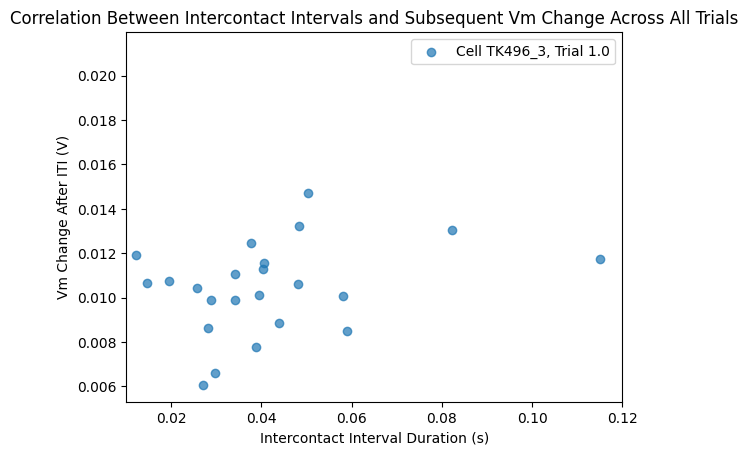

The Pearson Correlation Coefficient is: 0.17017638414515196 and the p-value is 0.6383338008967055


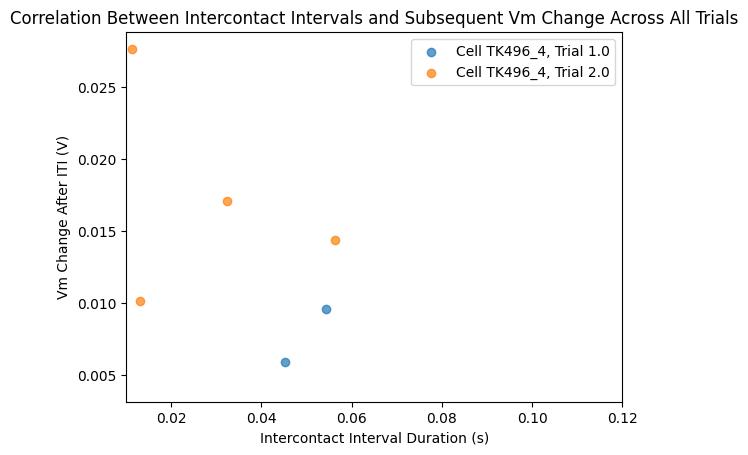

The Pearson Correlation Coefficient is: 0.266548234593653 and the p-value is 0.025716365933804892


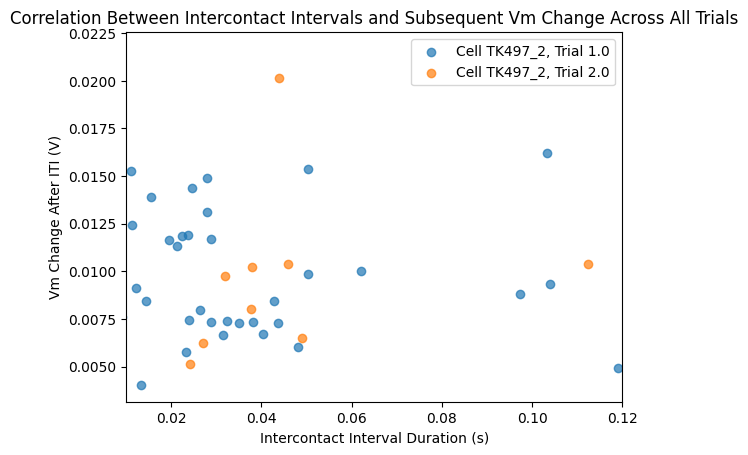

The Pearson Correlation Coefficient is: 0.37883107372433117 and the p-value is 0.28034450232197466


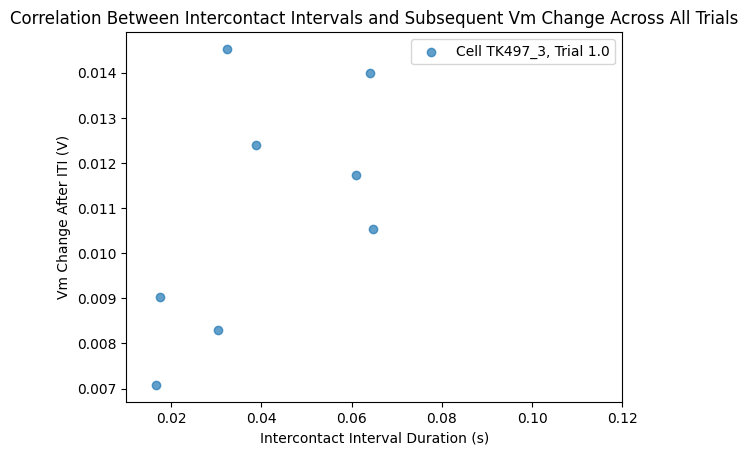

The Pearson Correlation Coefficient is: -0.0008908767506658692 and the p-value is 0.9975883719860767


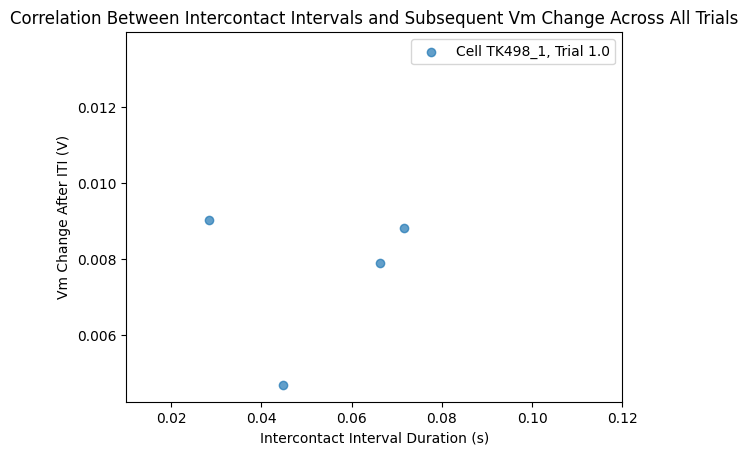

The Pearson Correlation Coefficient is: 0.24233724052099892 and the p-value is 0.006692527875739307


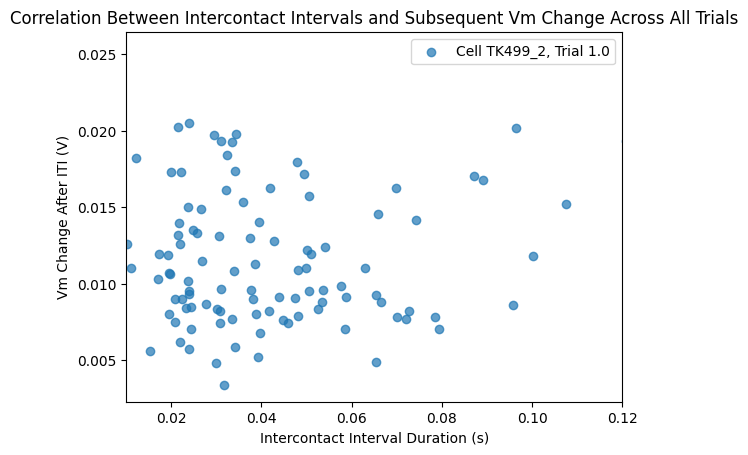

The Pearson Correlation Coefficient is: 0.03381700394663281 and the p-value is 0.7779393216227798


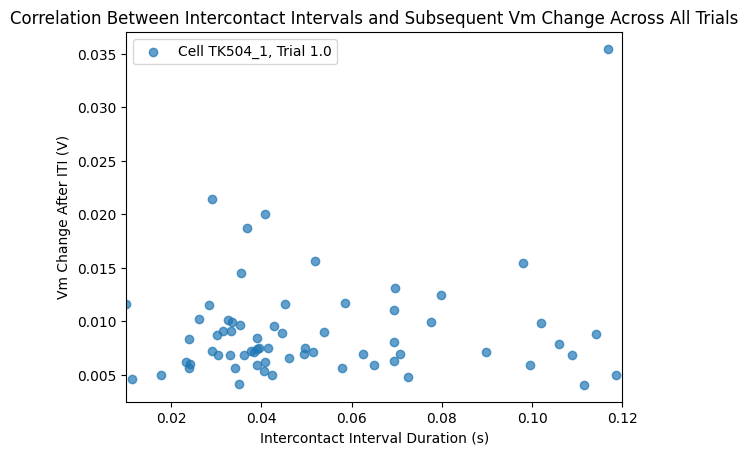

The Pearson Correlation Coefficient is: 0.26324642881930677 and the p-value is 0.03008625422932805


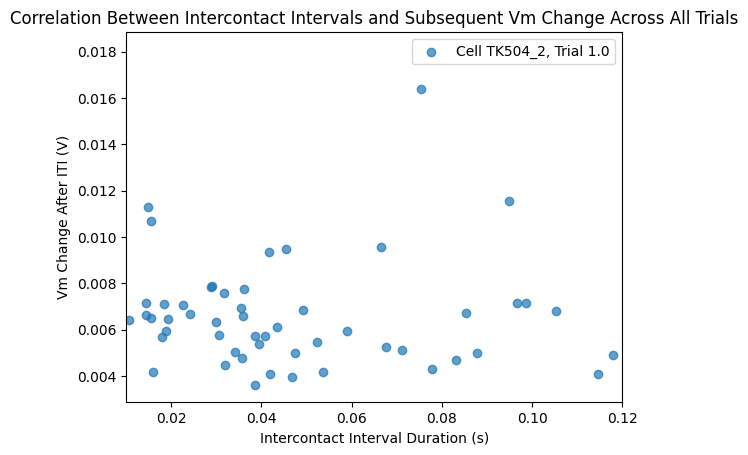

The Pearson Correlation Coefficient is: 0.8558336839007098 and the p-value is 1.495823839975157e-06


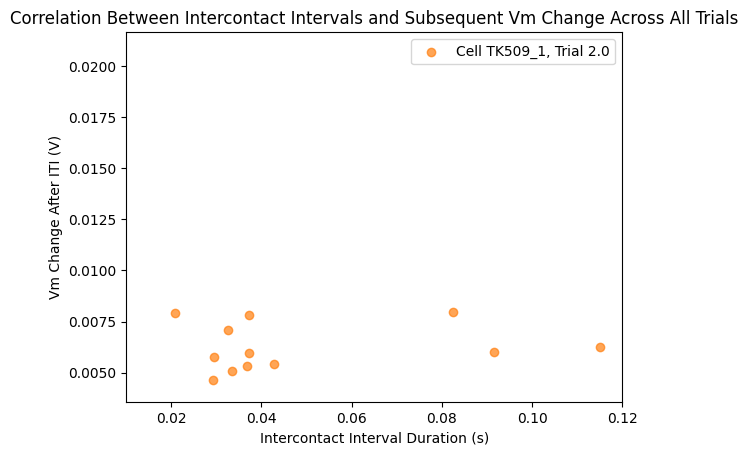

The Pearson Correlation Coefficient is: -0.4709257809866383 and the p-value is 0.017499891270611145


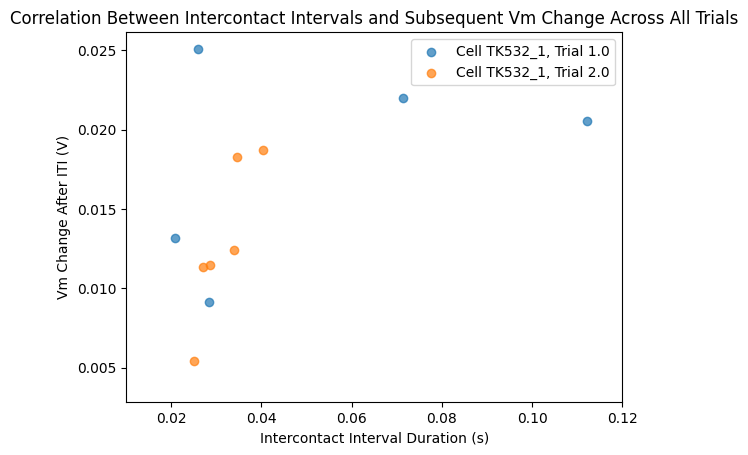

The Pearson Correlation Coefficient is: 0.09142648571745354 and the p-value is 0.6187279370219576


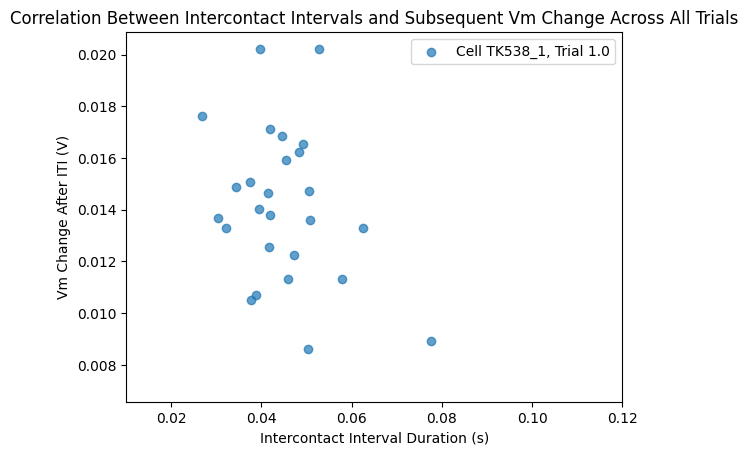

The Pearson Correlation Coefficient is: 0.18435027276404528 and the p-value is 0.06775147731046305


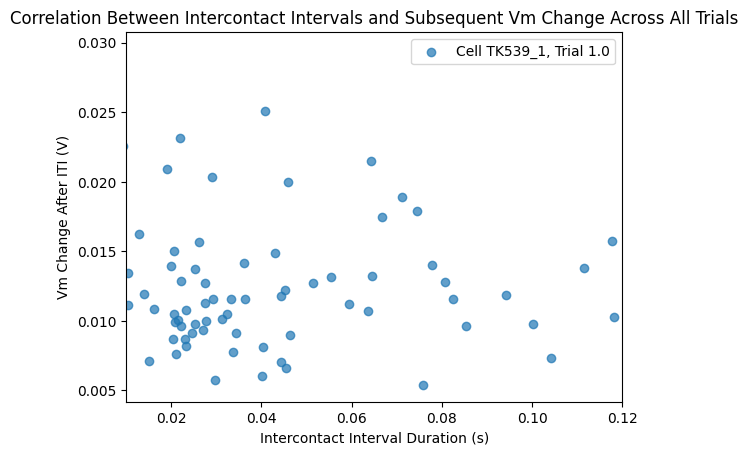

The Pearson Correlation Coefficient is: 0.06691293397877952 and the p-value is 0.6698700718060854


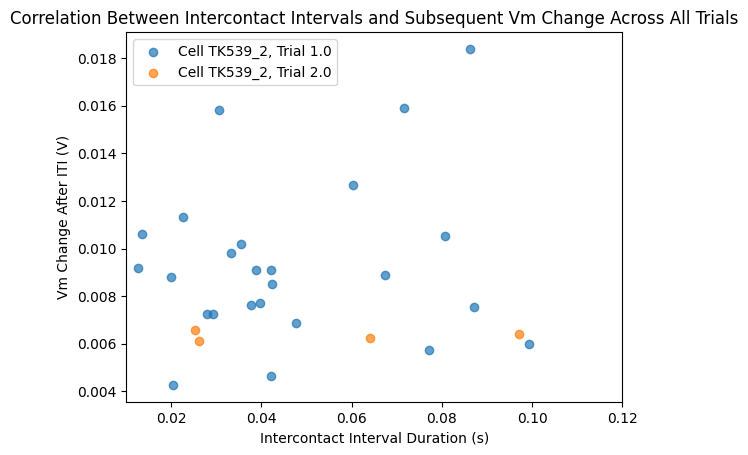

The Pearson Correlation Coefficient is: 0.005825110471338591 and the p-value is 0.9570439118883023


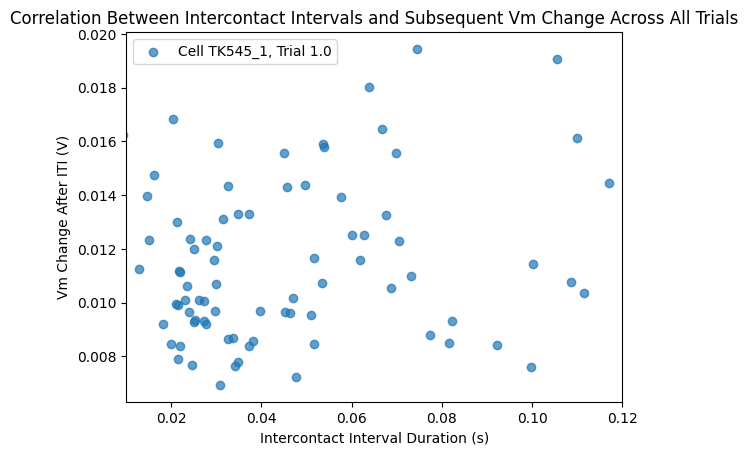

The Pearson Correlation Coefficient is: 0.8742816865871961 and the p-value is 0.052488913322897054


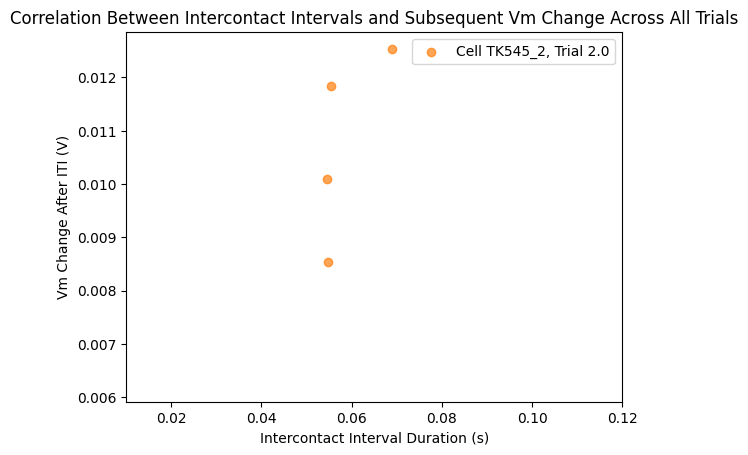

Top 3 highest Pearson Correlation Coefficients:
Cell TK545_2: Correlation = 0.874
Cell TK509_1: Correlation = 0.856
Cell SC917_1: Correlation = 0.432

Bottom 3 lowest Pearson Correlation Coefficients:
Cell TK408_1: Correlation = -0.236
Cell TK402_1: Correlation = -0.262
Cell TK532_1: Correlation = -0.471

Top 3 highest p-values:
Cell TK490_1: p-value = 0.956
Cell TK545_1: p-value = 0.957
Cell TK498_1: p-value = 0.998

Bottom 3 lowest p-values:
Cell SC925_1: p-value = 0.000
Cell SC917_1: p-value = 0.000
Cell TK509_1: p-value = 0.000


In [32]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors
from scipy.stats import pearsonr

# Prepare a colormap
colors = list(mcolors.TABLEAU_COLORS.values())  # Using Tableau colors for distinction
correlation_results = []

# Filter out only excitatory cells and skip the specified cell
skip_cells = ['AC32', 'JP902_1','JP907_1']
exc_cells = data_df_subset[data_df_subset['Cell_Type'] == 'EXC']
exc_cells = exc_cells[~exc_cells['Cell_ID'].isin(skip_cells)]

# Get a list of unique excitatory cell IDs
exc_cell_ids = np.unique(exc_cells['Cell_ID'])

plt.figure(figsize=(10, 6))

# Iterate over each cell
for cell_id in exc_cell_ids:
    all_iti_dur_tot = []
    all_vm_change_per_touch = []
    cell_df = exc_cells[exc_cells['Cell_ID'] == cell_id]
    trial_list = cell_df['Sweep_Counter'].unique()

    # Iterate over each trial for the cell
    for trial_idx, trial in enumerate(trial_list):
        cell_trial_df = cell_df[cell_df['Sweep_Counter'] == trial]
        # Extract active touch times and membrane potential
        active_touch_times = cell_trial_df['Sweep_ActiveContactTimes'].values[0]
        membrane_potential = cell_trial_df['Sweep_MembranePotential'].values[0]
        sr_vm = cell_trial_df['Sweep_MembranePotential_SamplingRate'].values[0]
        ap_vm_deriv_thresh = cell_df['Cell_APThreshold_Slope'].values[0]
        
        # Process the membrane potential to remove APs
        ap_params = Function_Detect_APs(membrane_potential, sr_vm, ap_vm_deriv_thresh)
        ap_peak_times = ap_params[:, 2]  # Assuming the third column contains AP peak times
        ap_thresh_times = ap_params[:, 0]  # Assuming the first column contains AP threshold times
        vm_subthreshold = Function_CutAPs(membrane_potential, sr_vm, ap_peak_times, ap_thresh_times)
        
        # Time array for indexing
        time_array = np.arange(len(vm_subthreshold)) / sr_vm
        
        # Calculate ITI durations and subsequent Vm changes
        active_touch_times_diff = []
        diff_vm = []
        for i in range (len(active_touch_times)-1):
            if active_touch_times[i+1][0]-active_touch_times[i][1]<0.5: 
                active_touch_times_diff.append(active_touch_times[i+1][0]-active_touch_times[i][1])
                test=membrane_potential[int(active_touch_times[i][1]*20000):int(active_touch_times[i+1][0]*20000)]
                diff_vm.append(max(test)-min(test))
        active_touch_times_diff = np.vstack(active_touch_times_diff)

        plt.scatter(active_touch_times_diff, diff_vm, color=colors[color_index % len(colors)], label=f'Cell {cell_id}, Trial {trial}')
        color_index += 1


    # Add labels, title, and legend
    plt.ylabel('diff_vm')
    plt.xlabel('ici')
    plt.title(f'Correlation Between diff_vm and ici Across Trials')
    plt.legend()

    # Show plot
    plt.show()

            


    if len(all_iti_dur_tot) > 1 and len(all_vm_change_per_touch) > 1:
        corr_coef, p_value = pearsonr(all_iti_dur_tot, all_vm_change_per_touch)
        correlation_results.append((cell_id, corr_coef, p_value))


        

        # Plot iti_dur_tot against post_iti_vm_change for each trial
        
    print("The Pearson Correlation Coefficient is:", corr_coef, "and the p-value is", p_value)
    # Label and title the plot
    plt.xlabel('Intercontact Interval Duration (s)')
    plt.ylabel('Vm Change After ITI (V)')
    plt.title('Correlation Between Intercontact Intervals and Subsequent Vm Change Across All Trials')
    plt.legend()
    plt.xlim(0.01,0.12)


    plt.show()
# Sort the results by correlation coefficients and p-values
sorted_by_corr = sorted(correlation_results, key=lambda x: x[1], reverse=True)  # Sort by correlation coefficient
sorted_by_p_value = sorted(correlation_results, key=lambda x: x[2])  # Sort by p-value

# Print top 3 and bottom 3 correlation coefficients
print("Top 3 highest Pearson Correlation Coefficients:")
for result in sorted_by_corr[:3]:
    print(f"Cell {result[0]}: Correlation = {result[1]:.3f}")

print("\nBottom 3 lowest Pearson Correlation Coefficients:")
for result in sorted_by_corr[-3:]:
    print(f"Cell {result[0]}: Correlation = {result[1]:.3f}")

# Print top 3 and bottom 3 p-values
print("\nTop 3 highest p-values:")
for result in sorted_by_p_value[-3:]:
    print(f"Cell {result[0]}: p-value = {result[2]:.3f}")

print("\nBottom 3 lowest p-values:")
for result in sorted_by_p_value[:3]:
    print(f"Cell {result[0]}: p-value = {result[2]:.3f}")

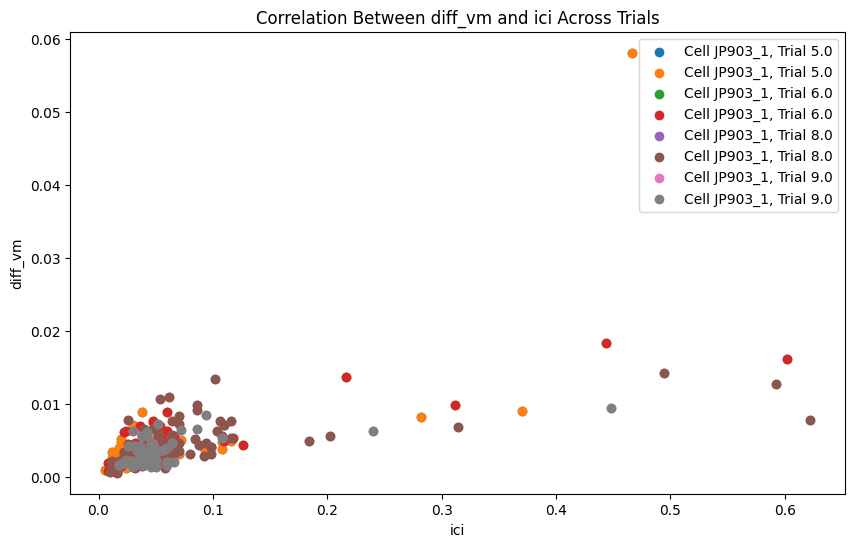

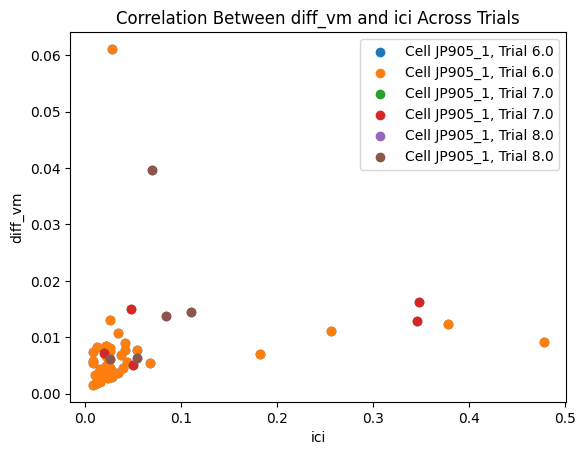

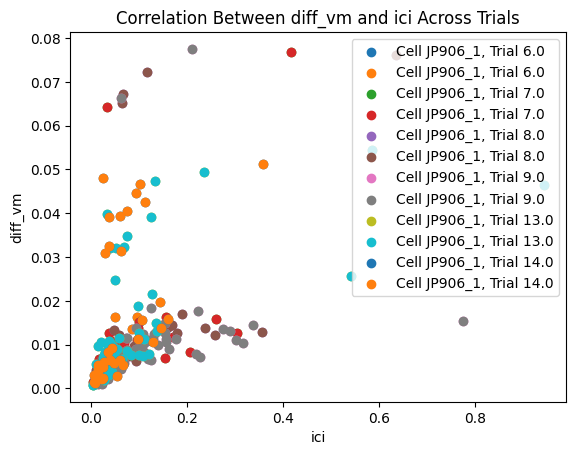

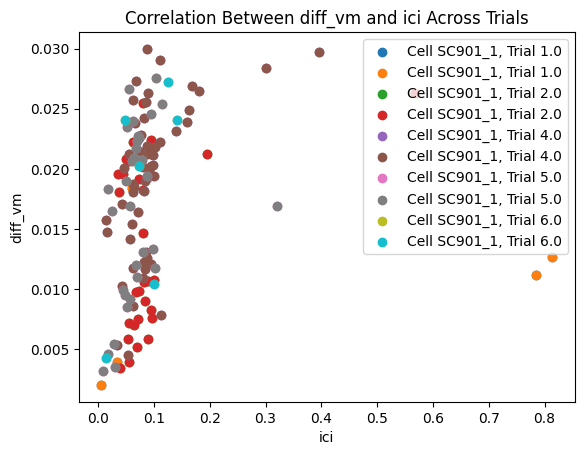

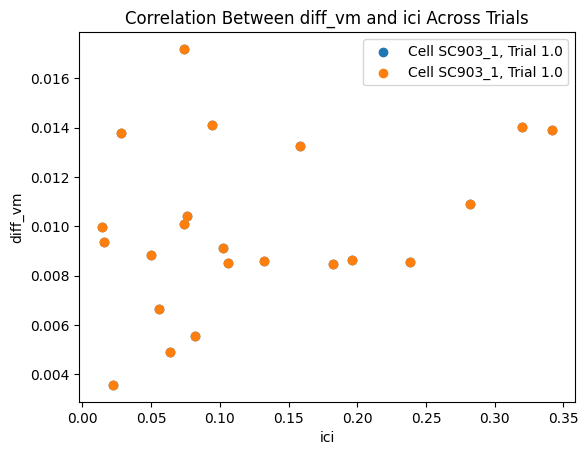

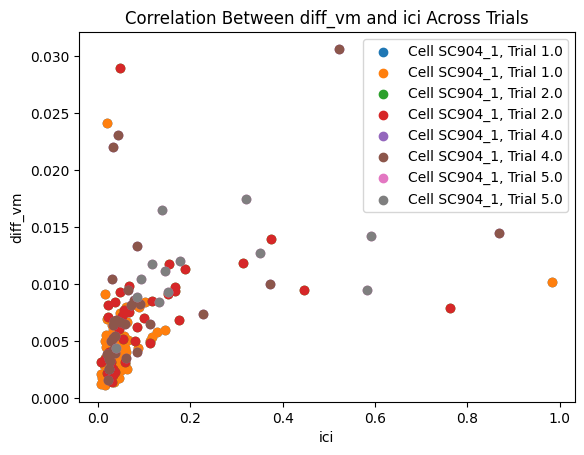

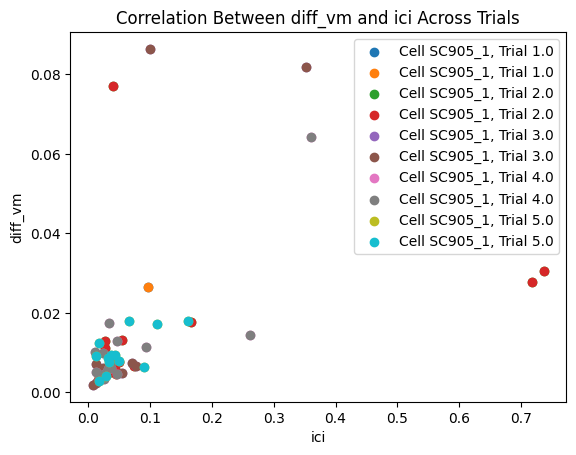

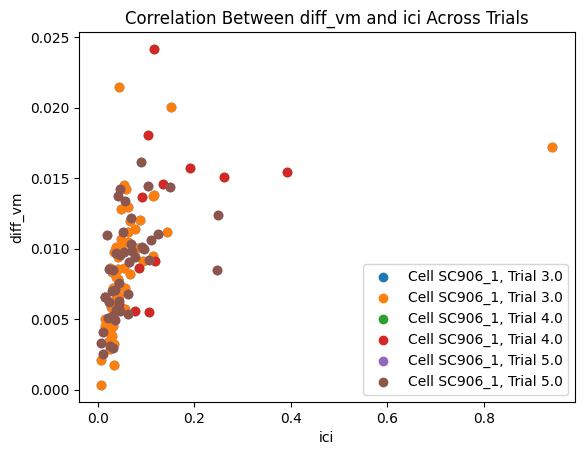

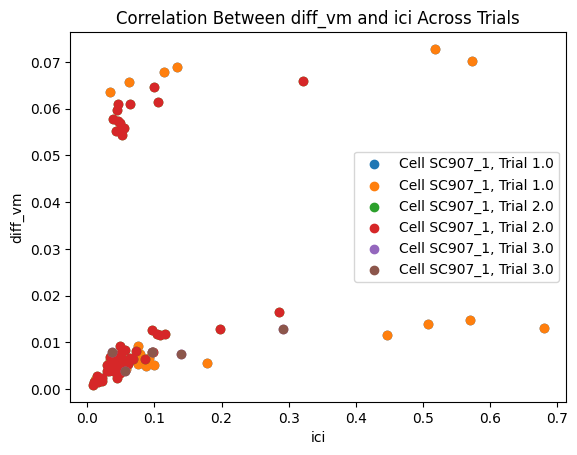

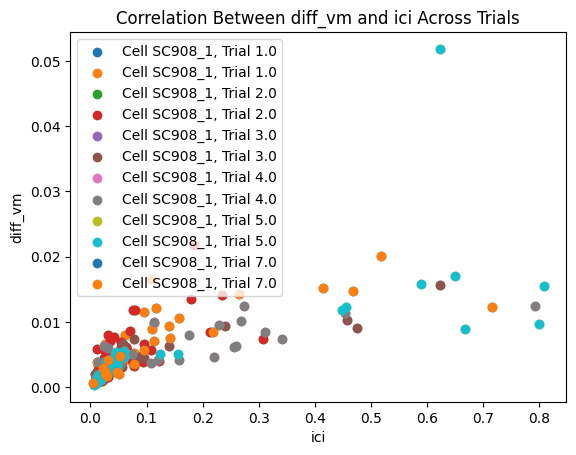

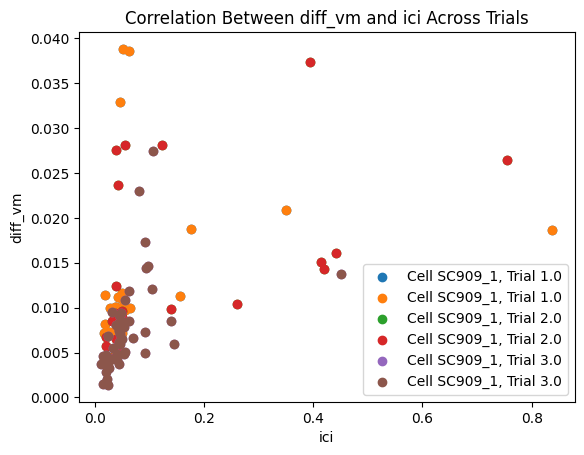

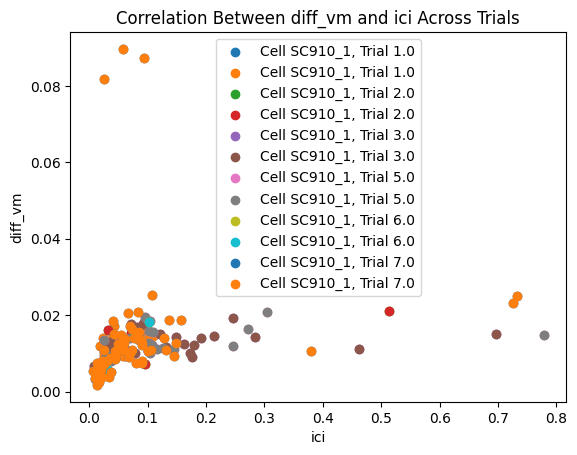

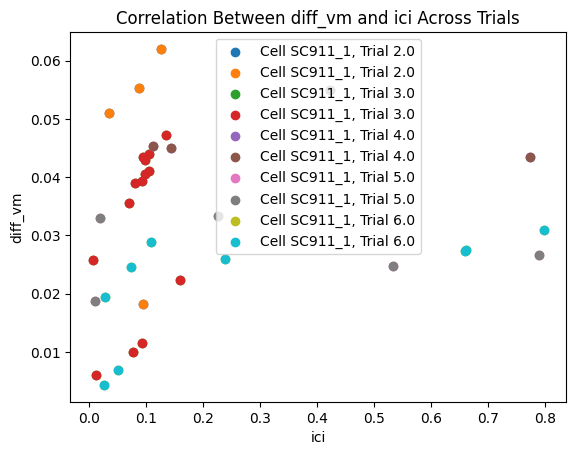

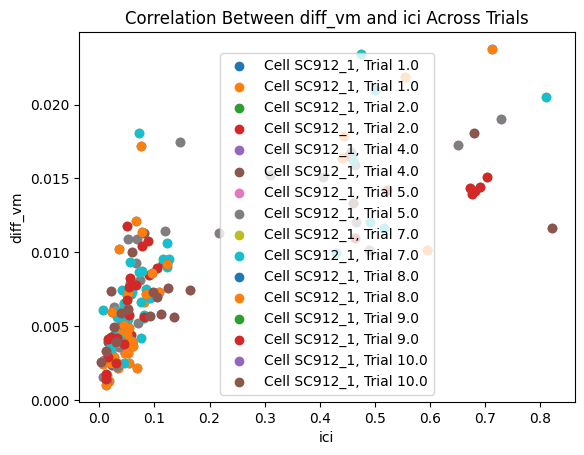

Skipping plot for cell SC913_1, trial 4.0 due to data mismatch
Skipping plot for cell SC913_1, trial 8.0 due to data mismatch


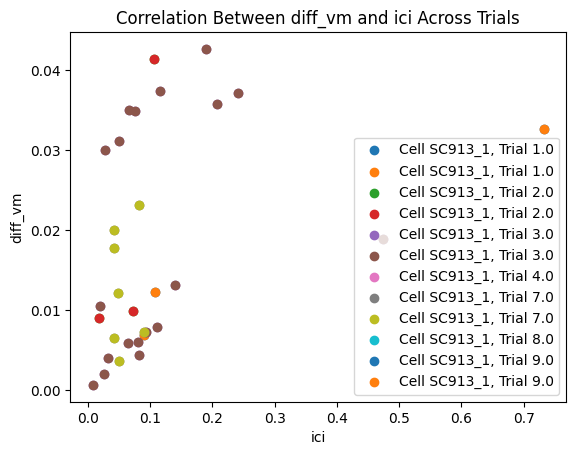

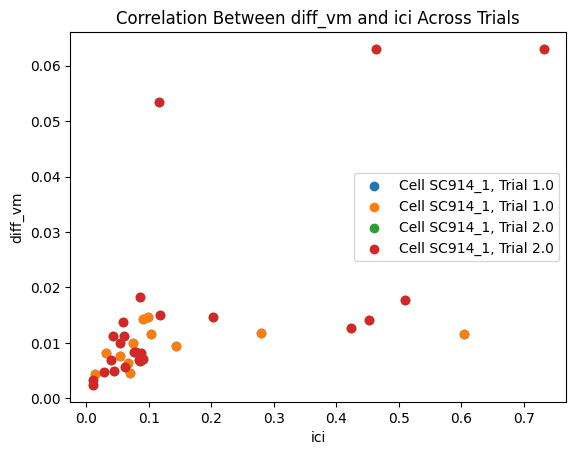

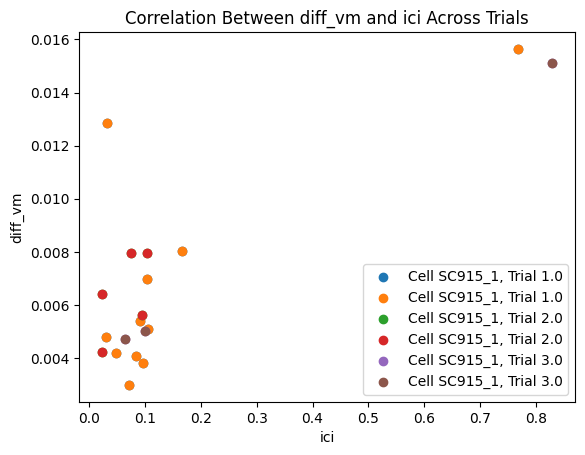

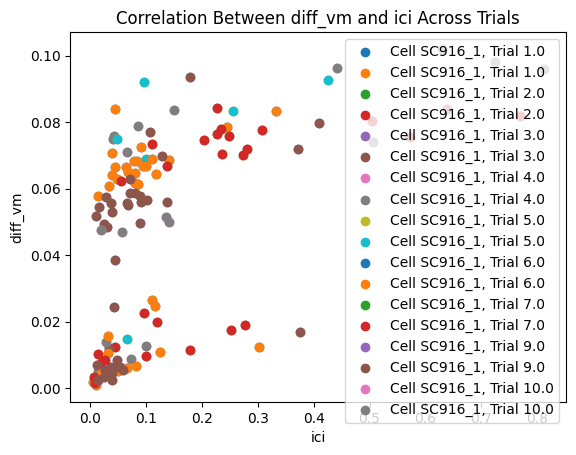

Skipping plot for cell SC917_1, trial 2.0 due to data mismatch


ValueError: x and y must be the same size

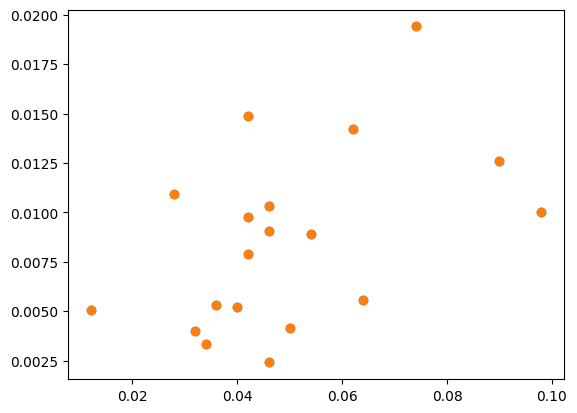

In [30]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors
from scipy.stats import pearsonr

# Prepare a colormap
colors = list(mcolors.TABLEAU_COLORS.values())  # Using Tableau colors for distinction
correlation_results = []

# Filter out only excitatory cells and skip the specified cell
skip_cells = ['AC32', 'JP902_1','JP907_1']
exc_cells = data_df_subset[data_df_subset['Cell_Type'] == 'EXC']
exc_cells = exc_cells[~exc_cells['Cell_ID'].isin(skip_cells)]

# Get a list of unique excitatory cell IDs
exc_cell_ids = np.unique(exc_cells['Cell_ID'])
def log_func(x, a, b):
    return a + b * np.log(x)

plt.figure(figsize=(10, 6))

# Iterate over each cell
for cell_id in exc_cell_ids:
    all_iti_dur_tot = []
    all_vm_change_per_touch = []
    cell_df = exc_cells[exc_cells['Cell_ID'] == cell_id]
    trial_list = cell_df['Sweep_Counter'].unique()

    # Iterate over each trial for the cell
    for trial_idx, trial in enumerate(trial_list):
        cell_trial_df = cell_df[cell_df['Sweep_Counter'] == trial]
        # Extract active touch times and membrane potential
        active_touch_times = cell_trial_df['Sweep_ActiveContactTimes'].values[0]
        membrane_potential = cell_trial_df['Sweep_MembranePotential'].values[0]
        sr_vm = cell_trial_df['Sweep_MembranePotential_SamplingRate'].values[0]
        ap_vm_deriv_thresh = cell_df['Cell_APThreshold_Slope'].values[0]
        
        # Process the membrane potential to remove APs
        ap_params = Function_Detect_APs(membrane_potential, sr_vm, ap_vm_deriv_thresh)
        ap_peak_times = ap_params[:, 2]  # Assuming the third column contains AP peak times
        ap_thresh_times = ap_params[:, 0]  # Assuming the first column contains AP threshold times
        vm_subthreshold = Function_CutAPs(membrane_potential, sr_vm, ap_peak_times, ap_thresh_times)
        
        # Time array for indexing
        time_array = np.arange(len(vm_subthreshold)) / sr_vm
        
        # Calculate ITI durations and subsequent Vm changes
        active_touch_times_diff = []
        diff_vm = []
        if isinstance(active_touch_times, np.ndarray) and active_touch_times.ndim == 2:
            for i in range (len(active_touch_times)-1):
                if active_touch_times[i+1][0]-active_touch_times[i][1]<1: 
                    ici_duration = active_touch_times[i+1][0] - active_touch_times[i][1]
                    active_touch_times_diff.append([ici_duration])

                    start_idx = int(active_touch_times[i][1] * sr_vm)
                    end_idx = int(active_touch_times[i+1][0] * sr_vm)
                    if start_idx < end_idx and start_idx < len(membrane_potential):
                        test = membrane_potential[start_idx:end_idx]
                        if len(test) > 0:
                            diff_vm.append(max(test) - min(test))
                        else:
                            diff_vm.append(np.nan)
            
            if active_touch_times_diff and len(active_touch_times_diff) == len(diff_vm):
                
                active_touch_times_diff_array = np.array(active_touch_times_diff)
                
                plt.scatter(active_touch_times_diff_array, diff_vm, label=f'Cell {cell_id}, Trial {trial}')
            else:
                print(f"Skipping plot for cell {cell_id}, trial {trial} due to data mismatch")
        else:
            continue

        
        plt.scatter(active_touch_times_diff, diff_vm,  label=f'Cell {cell_id}, Trial {trial}')
        

    # Add labels, title, and legend
    plt.ylabel('diff_vm')
    plt.xlabel('ici')
    plt.title(f'Correlation Between diff_vm and ici Across Trials')
    plt.legend()

    # Show plot
    plt.show()

            




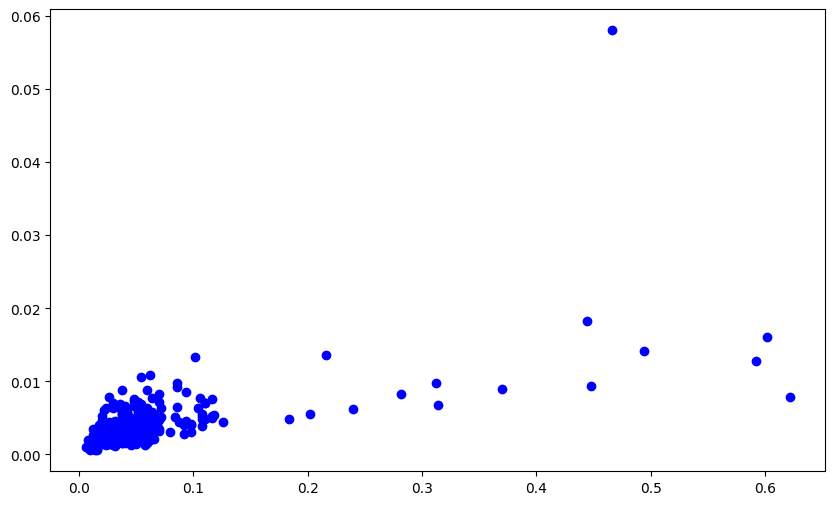

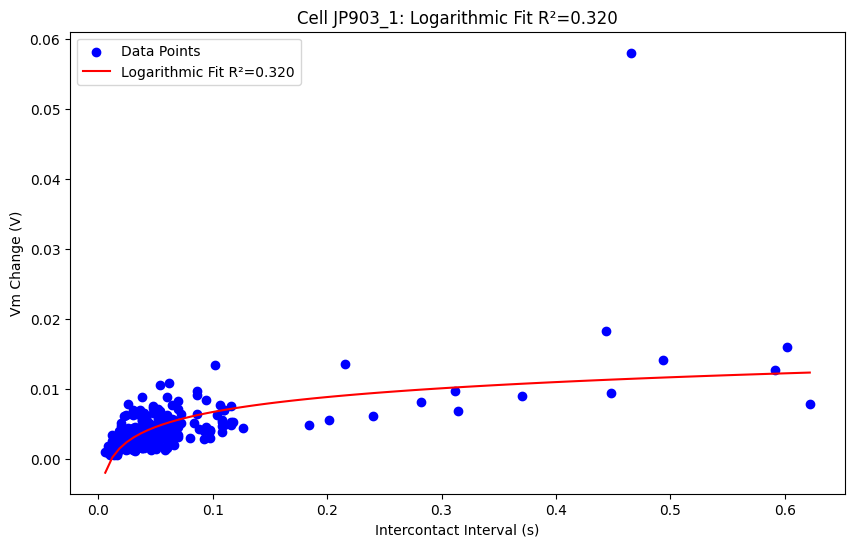

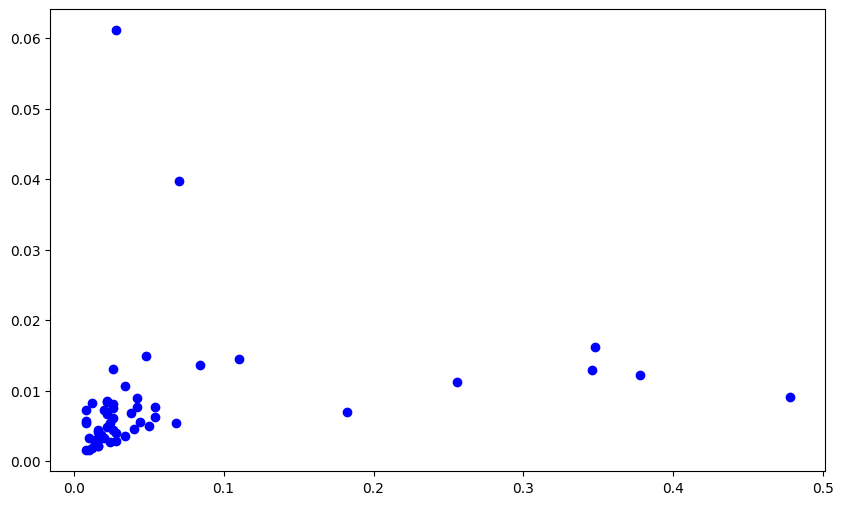

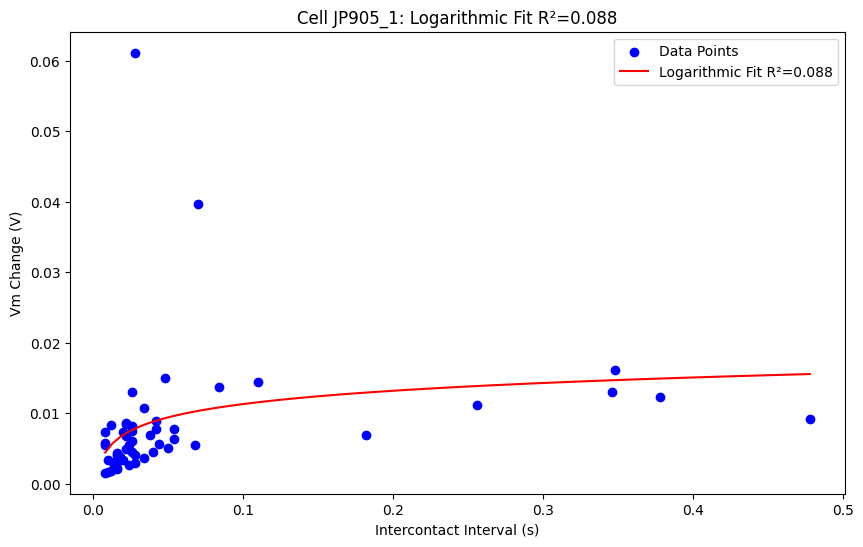

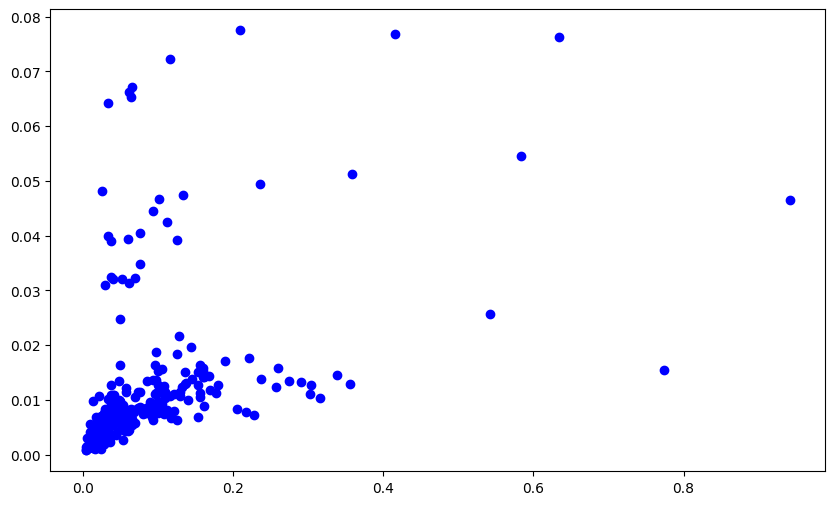

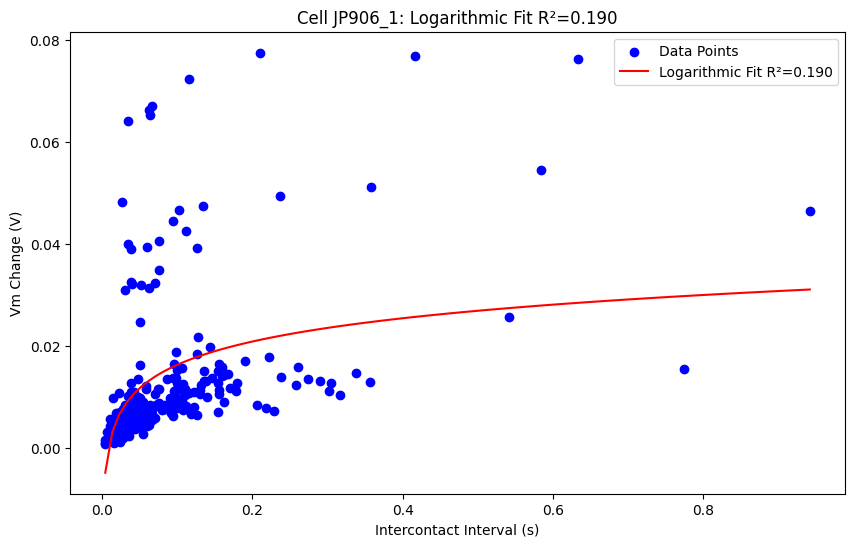

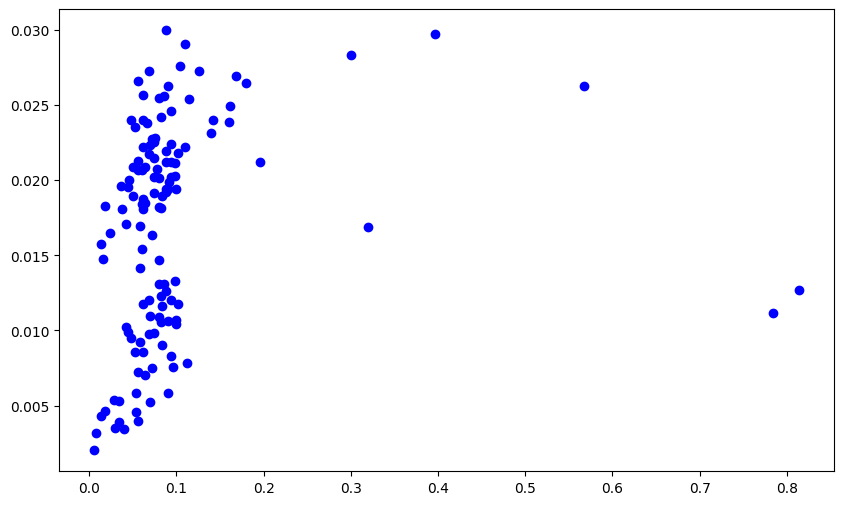

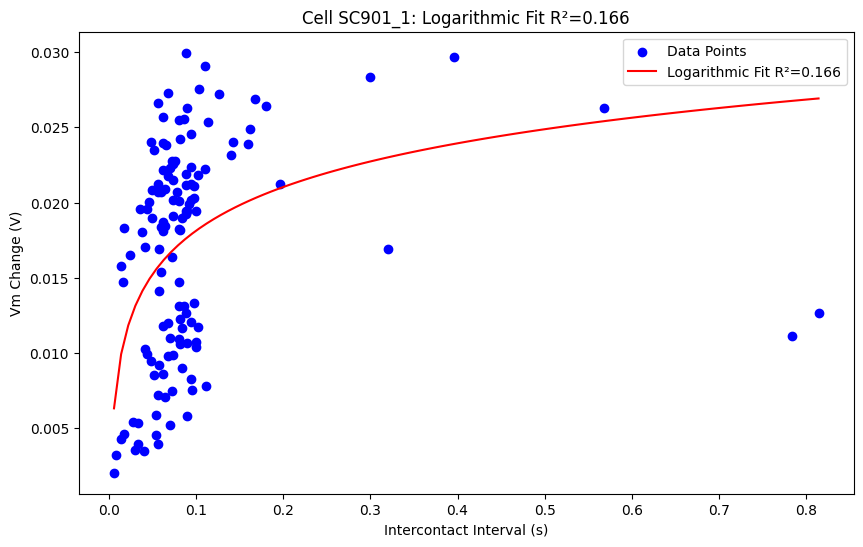

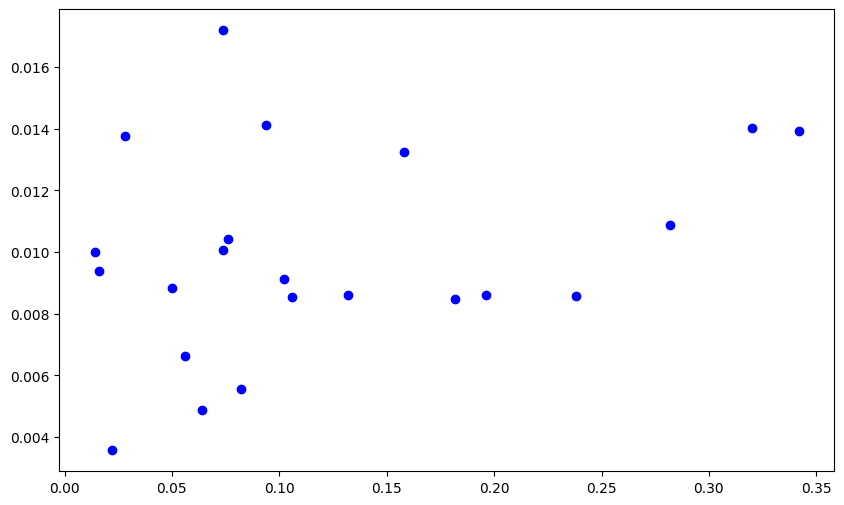

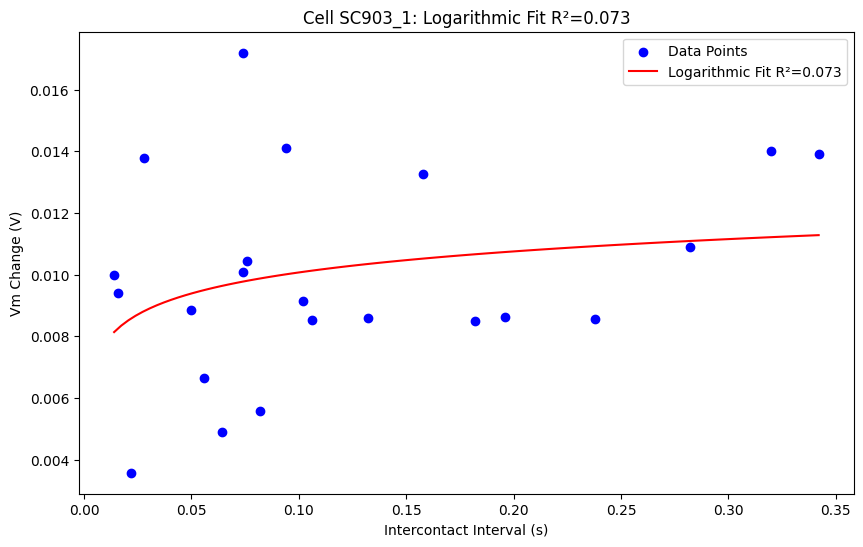

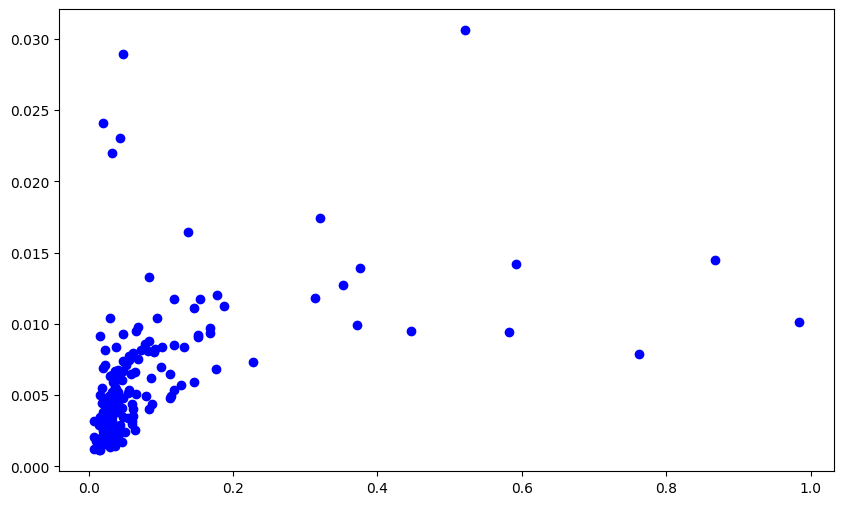

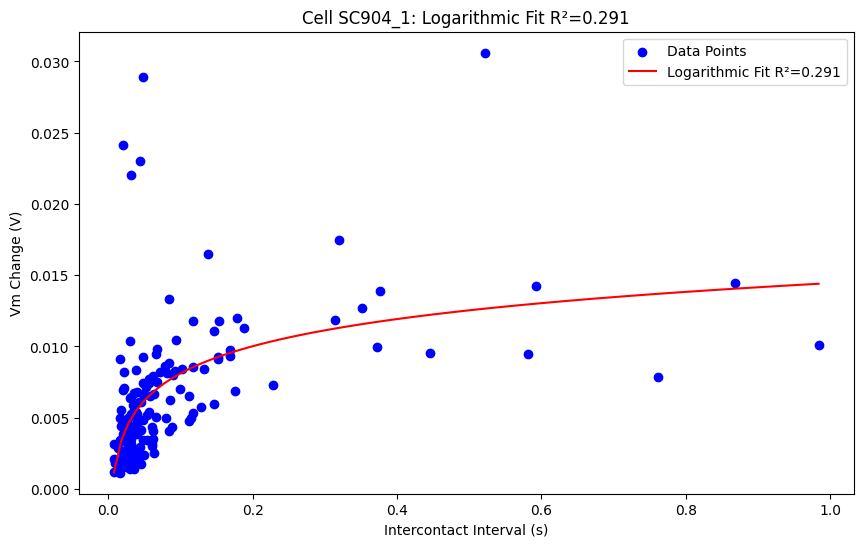

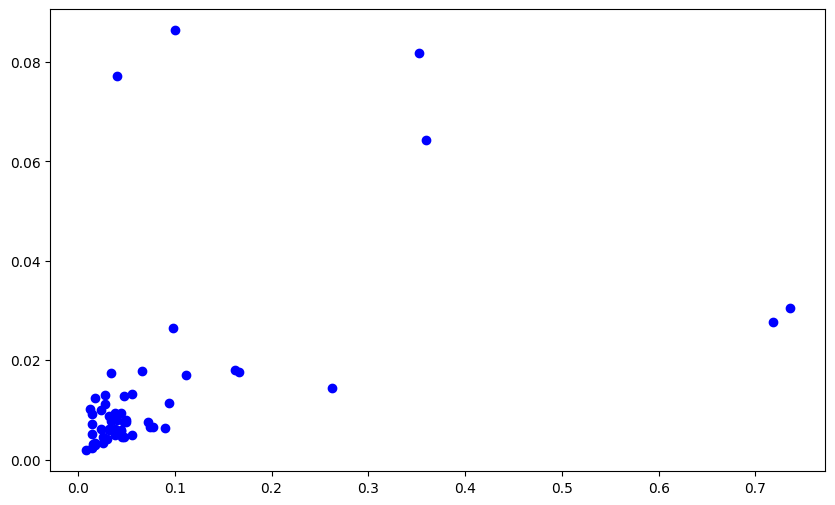

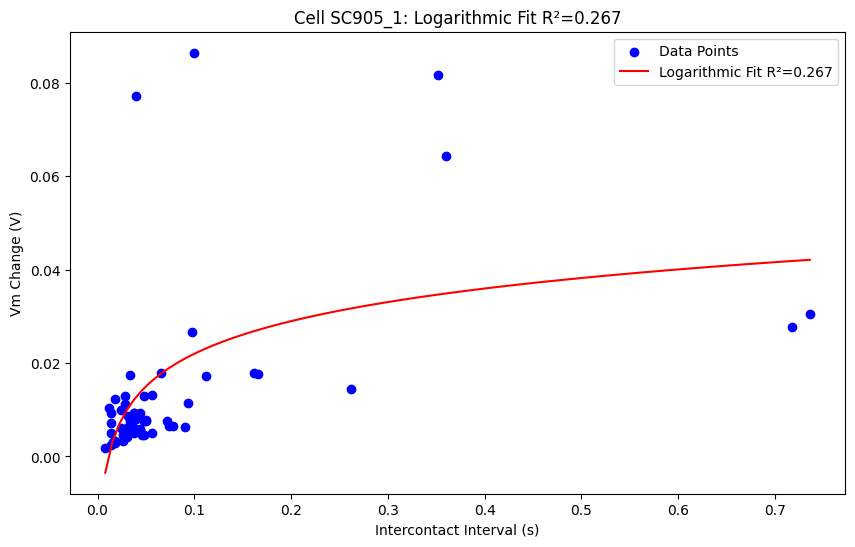

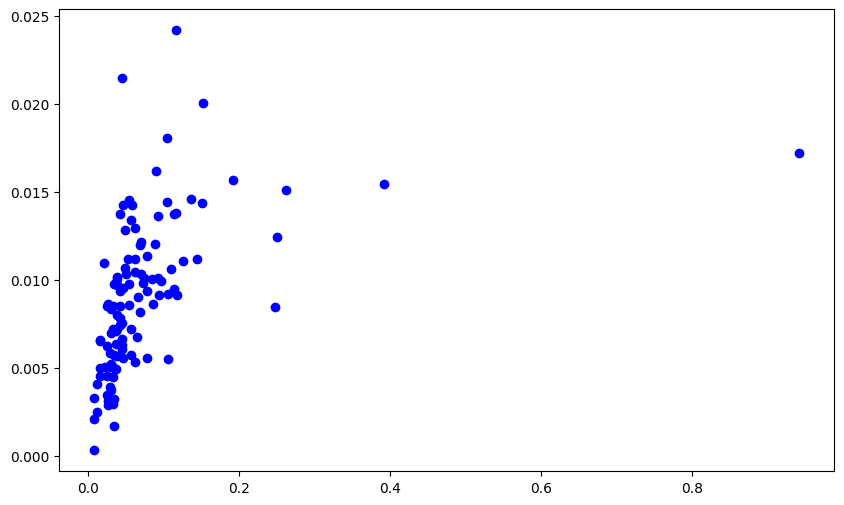

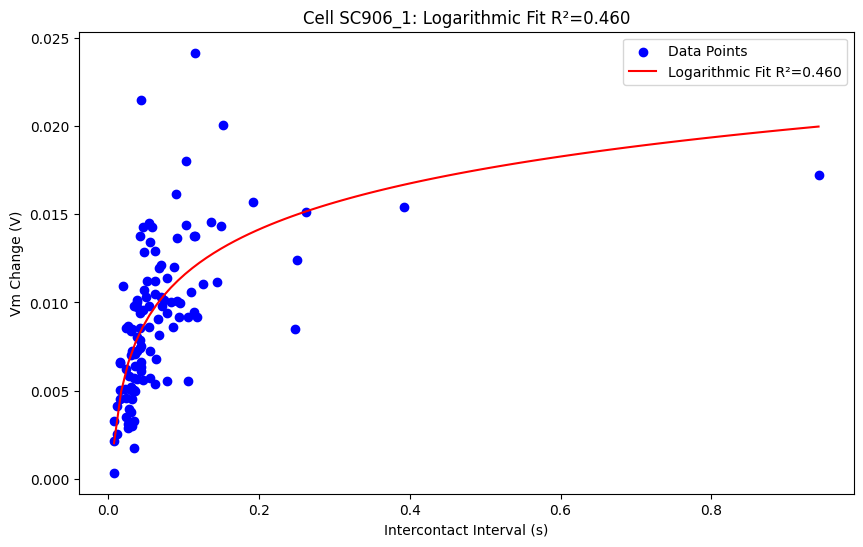

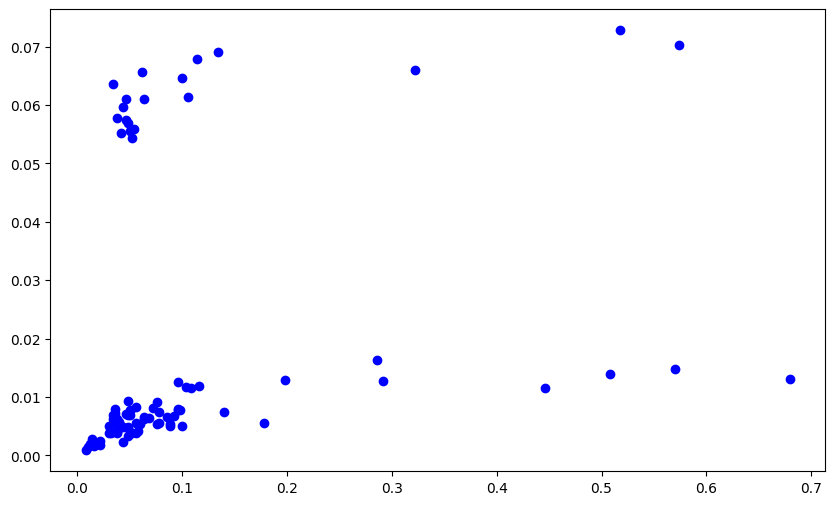

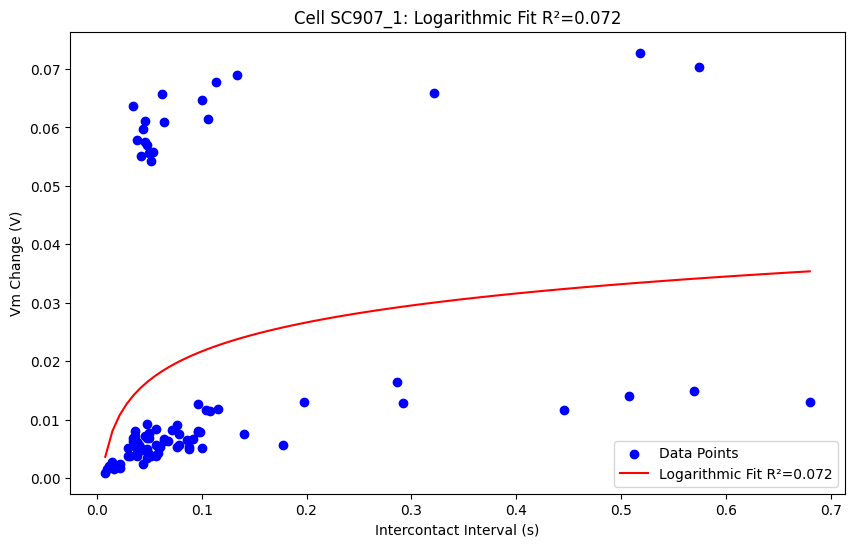

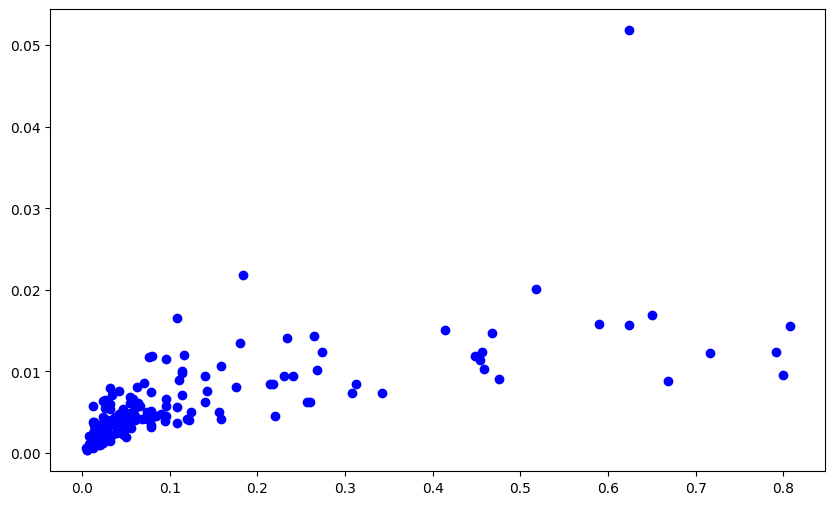

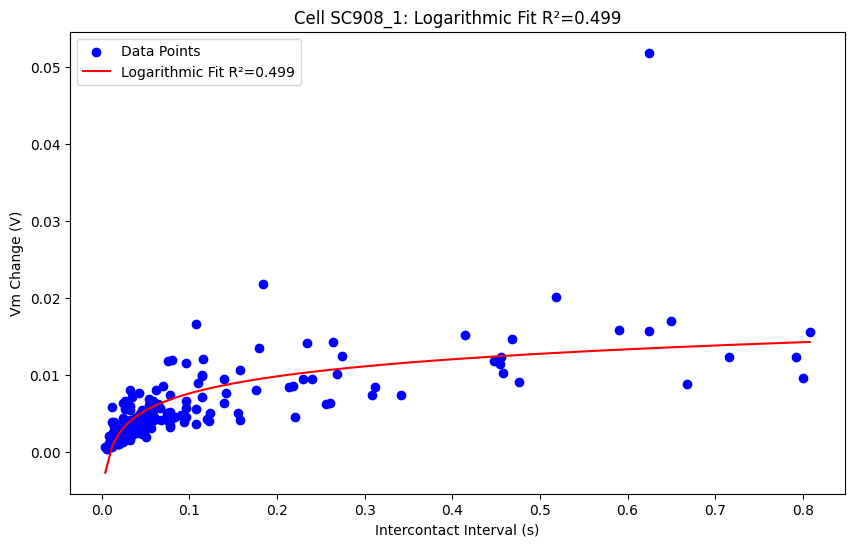

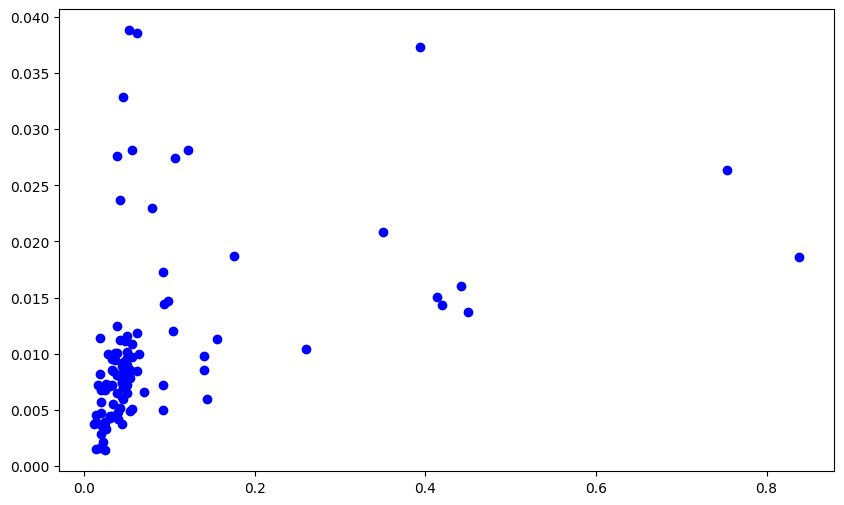

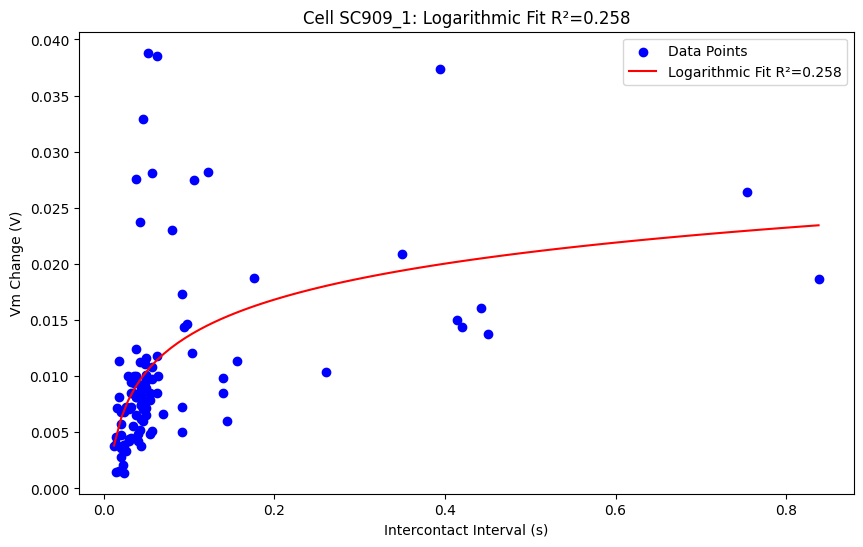

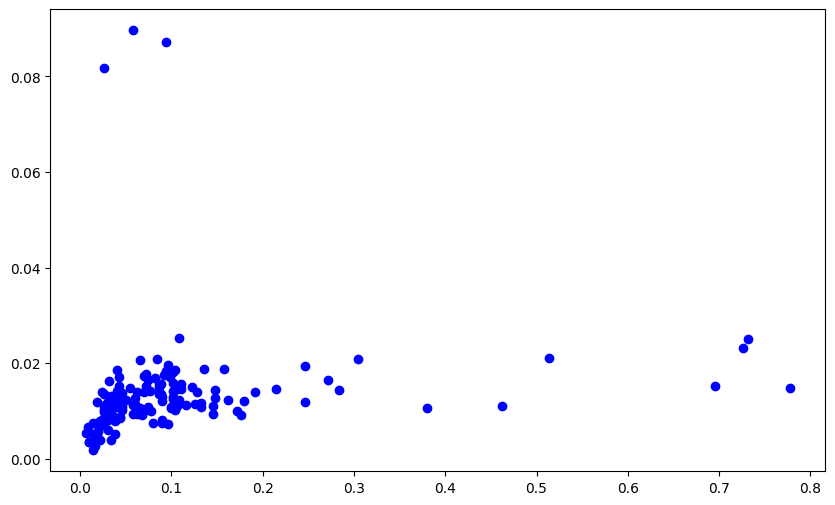

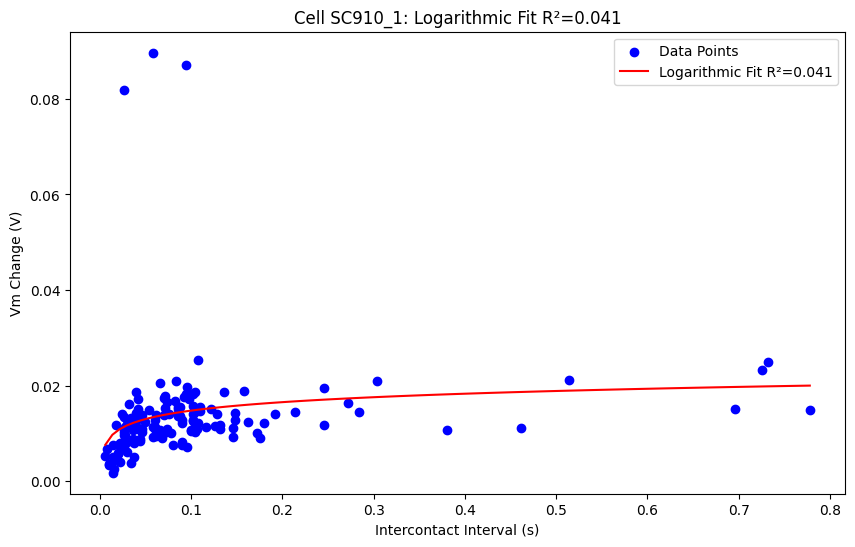

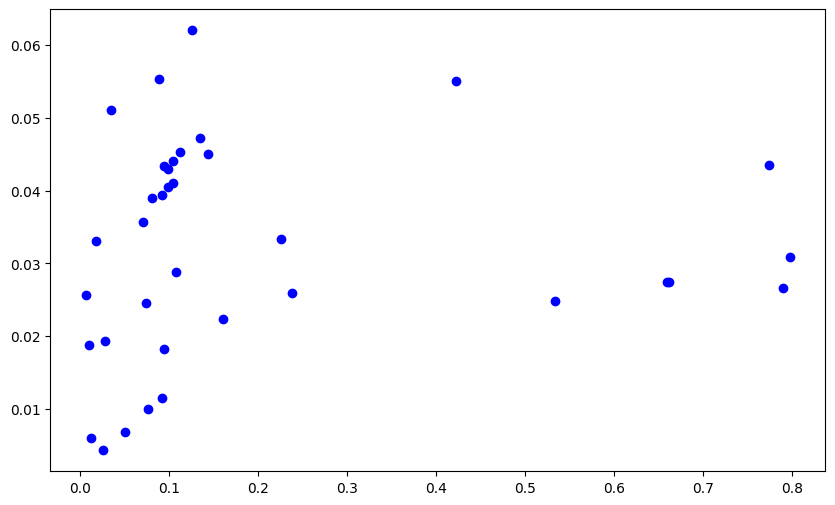

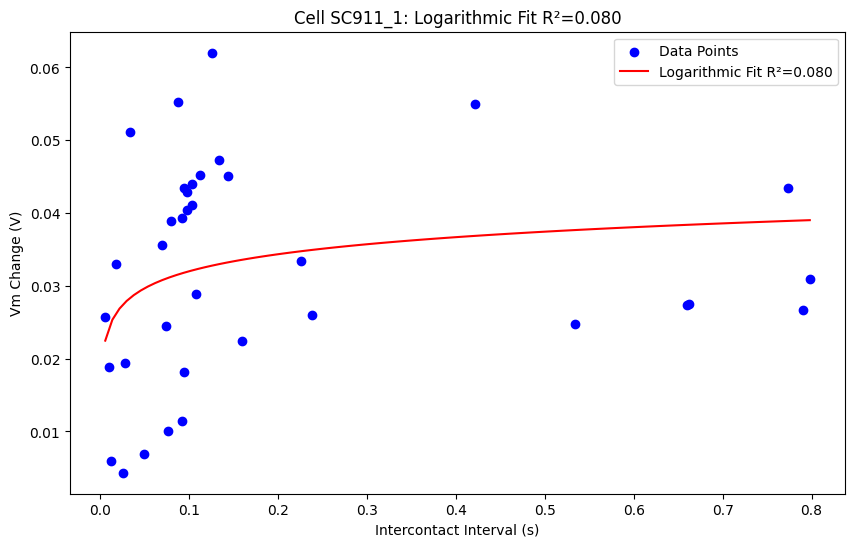

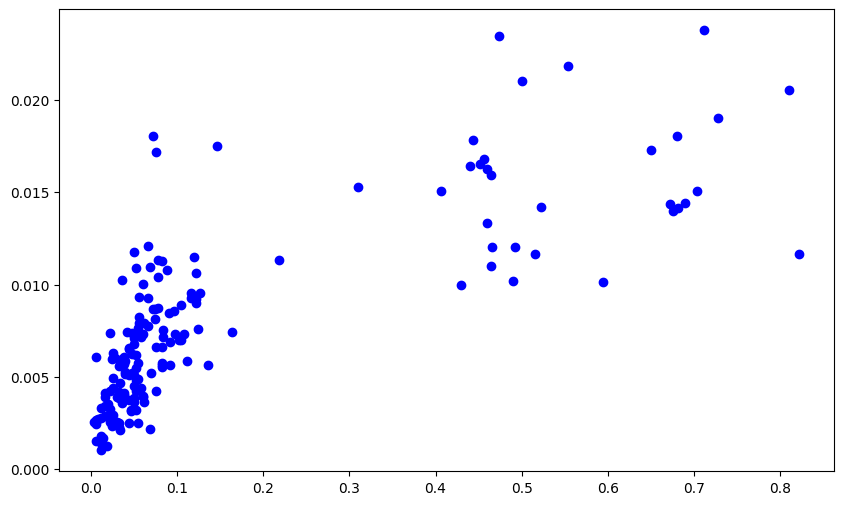

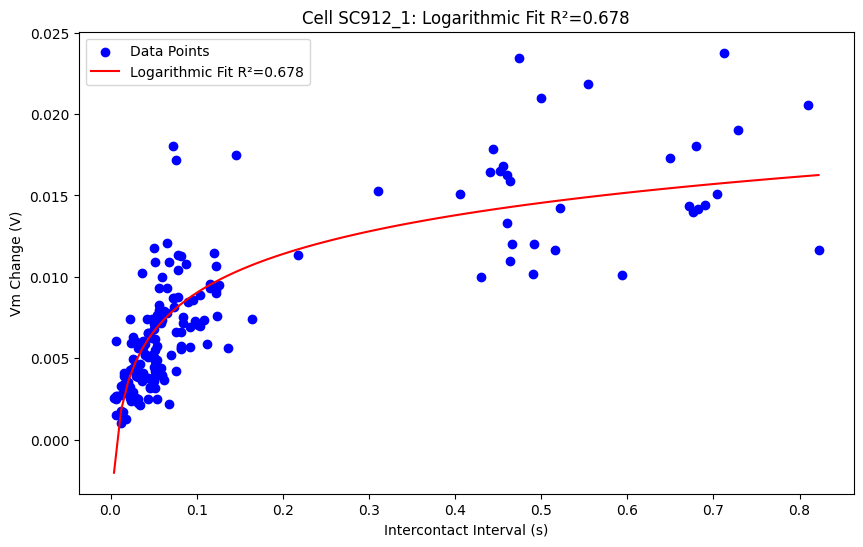

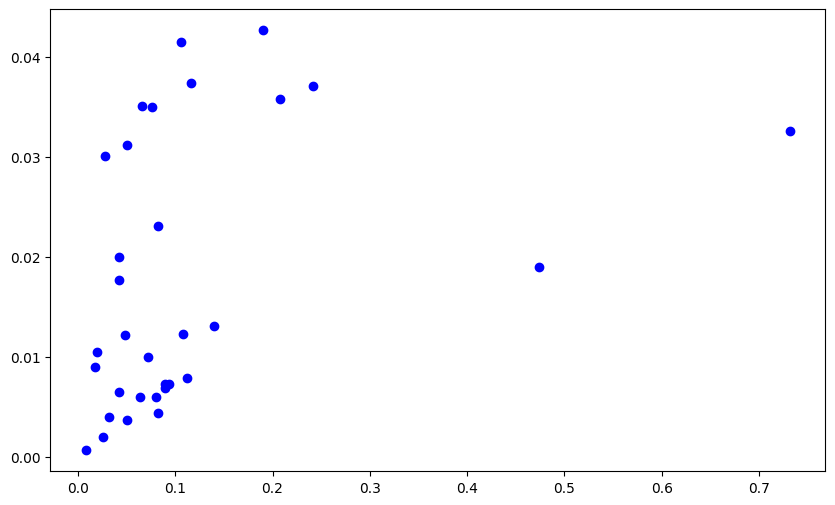

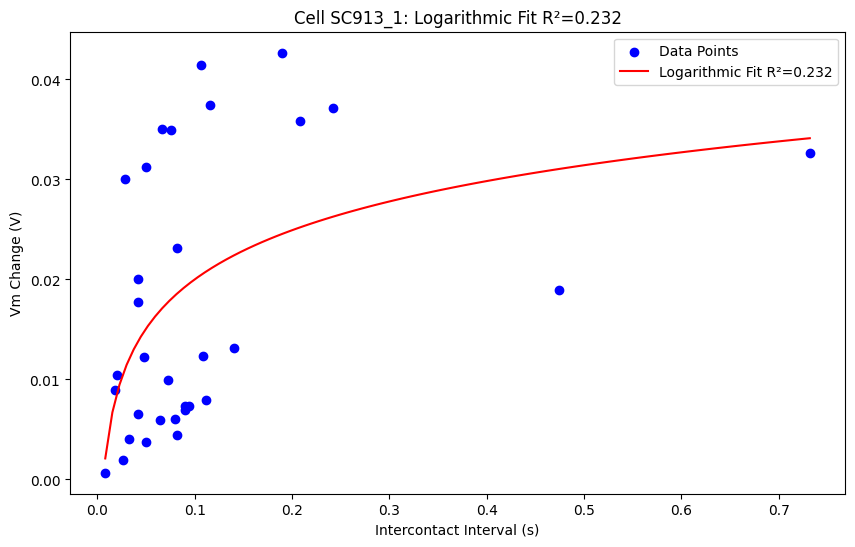

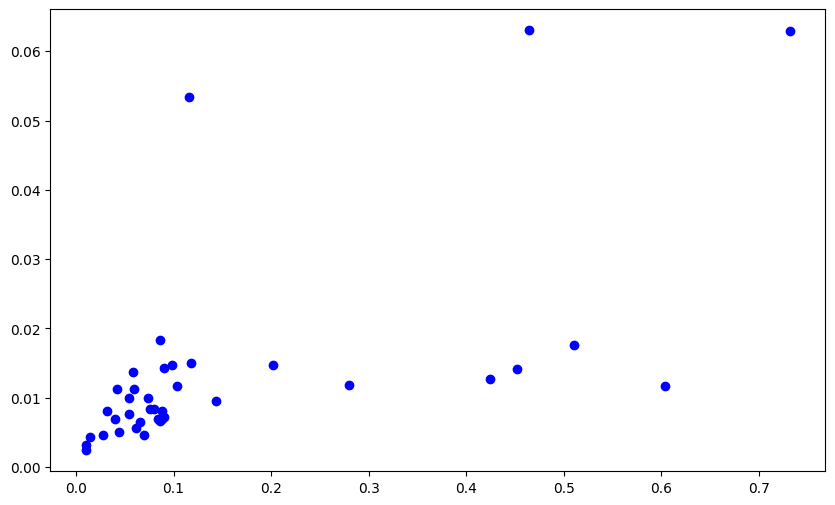

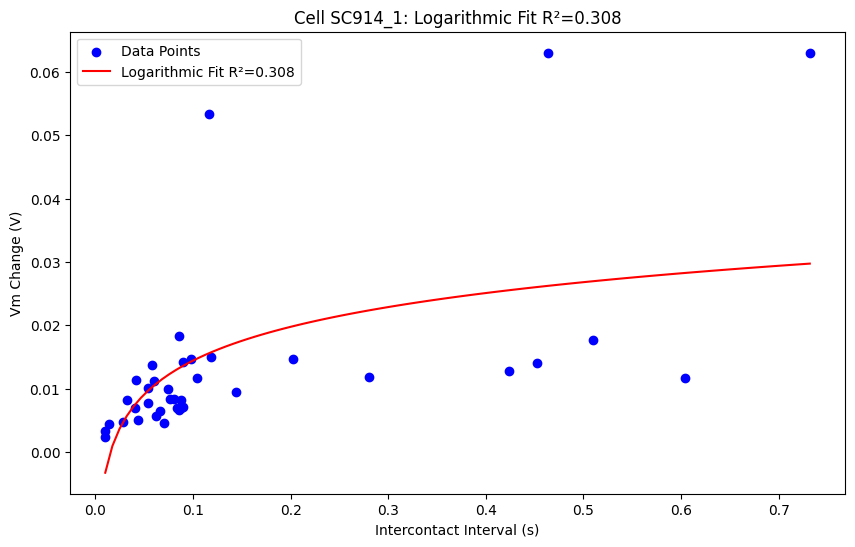

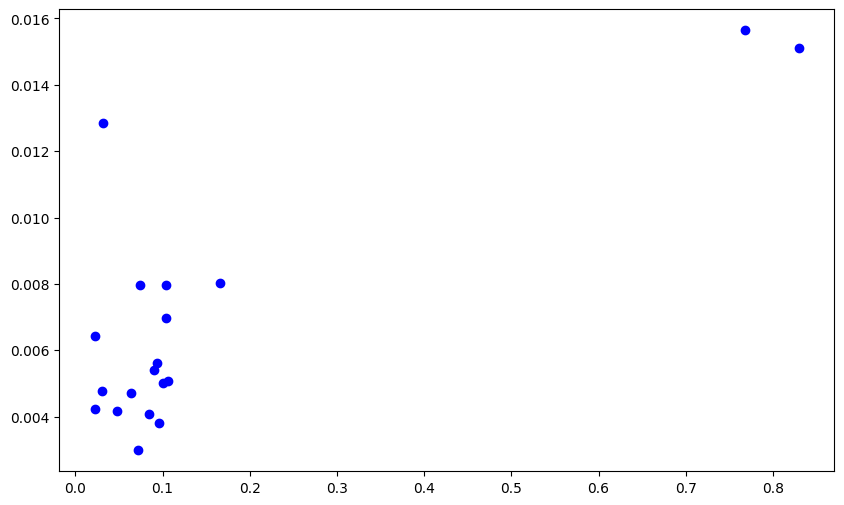

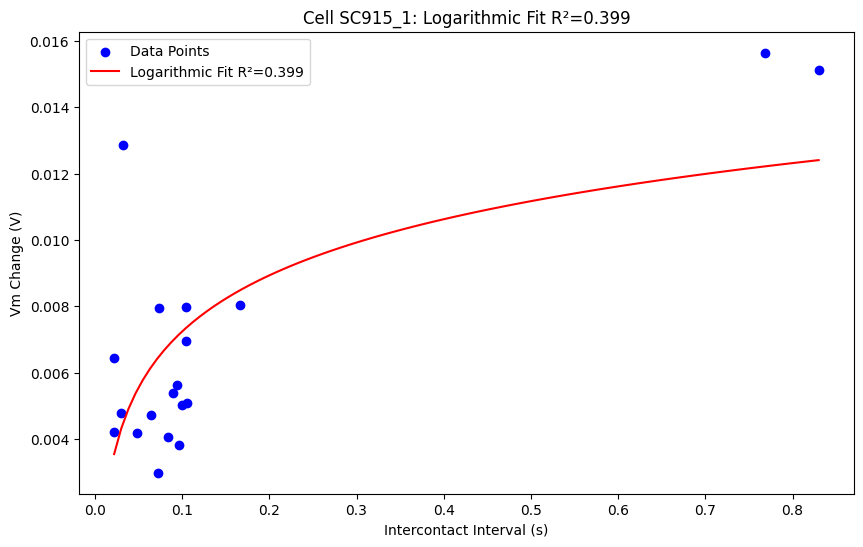

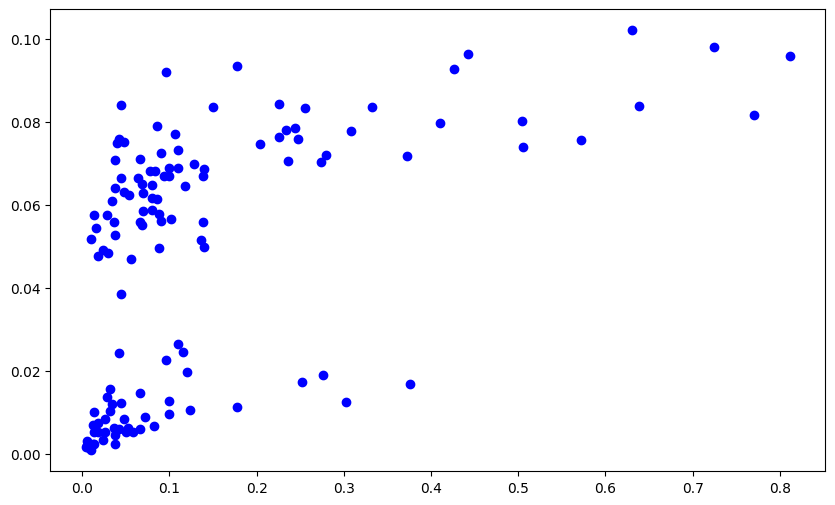

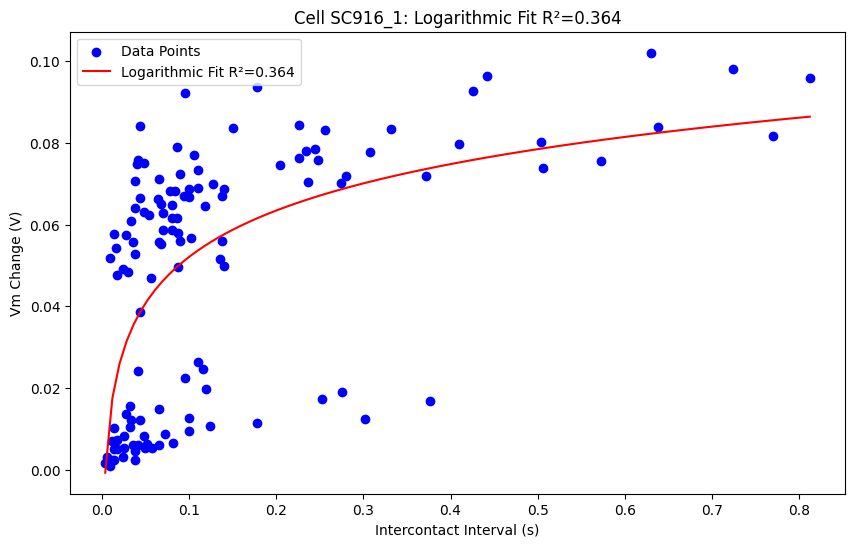

ValueError: operands could not be broadcast together with shapes (136,) (134,) 

In [42]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors
from scipy.optimize import curve_fit

# Define the logarithmic function for curve fitting
def log_func(x, a, b):
    return a + b * np.log(x)

# Prepare a colormap
colors = list(mcolors.TABLEAU_COLORS.values())

# Filter out specific cells and get unique excitatory cell IDs
skip_cells = ['AC32', 'JP902_1', 'JP907_1']
exc_cells = data_df_subset[data_df_subset['Cell_Type'] == 'EXC']
exc_cells = exc_cells[~exc_cells['Cell_ID'].isin(skip_cells)]
exc_cell_ids = np.unique(exc_cells['Cell_ID'])

# Iterate over each cell
for cell_id in exc_cell_ids:
    all_ici_durations = []
    all_diff_vm = []
    cell_df = exc_cells[exc_cells['Cell_ID'] == cell_id]
    trial_list = cell_df['Sweep_Counter'].unique()

    # Collect data from all trials for the cell
    for trial in trial_list:
        cell_trial_df = cell_df[cell_df['Sweep_Counter'] == trial]
        active_touch_times = cell_trial_df['Sweep_ActiveContactTimes'].values[0]
        membrane_potential = cell_trial_df['Sweep_MembranePotential'].values[0]
        sr_vm = cell_trial_df['Sweep_MembranePotential_SamplingRate'].values[0]
        ap_vm_deriv_thresh = cell_df['Cell_APThreshold_Slope'].values[0]
        
        # Process the membrane potential to remove APs
        ap_params = Function_Detect_APs(membrane_potential, sr_vm, ap_vm_deriv_thresh)
        ap_peak_times = ap_params[:, 2]  # Assuming the third column contains AP peak times
        ap_thresh_times = ap_params[:, 0]  # Assuming the first column contains AP threshold times
        vm_subthreshold = Function_CutAPs(membrane_potential, sr_vm, ap_peak_times, ap_thresh_times)
        
        # Time array for indexing
        time_array = np.arange(len(vm_subthreshold)) / sr_vm

        if isinstance(active_touch_times, np.ndarray) and active_touch_times.ndim == 2:
            for i in range(len(active_touch_times)-1):
                if active_touch_times[i+1][0] - active_touch_times[i][1] < 1: 
                    ici_duration = active_touch_times[i+1][0] - active_touch_times[i][1]
                    all_ici_durations.append(ici_duration)

                    start_idx = int(active_touch_times[i][1] * sr_vm)
                    end_idx = int(active_touch_times[i+1][0] * sr_vm)
                    if start_idx < end_idx and start_idx < len(membrane_potential):
                        test = membrane_potential[start_idx:end_idx]
                        if len(test) > 0:
                            all_diff_vm.append(max(test) - min(test))

    # Convert lists to numpy arrays
    all_ici_durations_array = np.array(all_ici_durations)
    all_diff_vm_array = np.array(all_diff_vm)

    # Filter out invalid data points
    valid_indices = (~np.isnan(all_ici_durations_array) & 
                     ~np.isnan(all_diff_vm_array) & 
                     (all_ici_durations_array > 0))

    # Perform curve fitting if valid data exists
    if valid_indices.any():
        popt, _ = curve_fit(log_func, all_ici_durations_array[valid_indices], all_diff_vm_array[valid_indices])

        # Generate a range of x values for plotting the fit curve
        fitted_x = np.linspace(min(all_ici_durations_array[valid_indices]), max(all_ici_durations_array[valid_indices]), 100)
        fitted_y = log_func(fitted_x, *popt)

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.scatter(all_ici_durations_array, all_diff_vm_array, color='blue', label='Data Points')
    if valid_indices.any():
        popt, _ = curve_fit(log_func, all_ici_durations_array[valid_indices], all_diff_vm_array[valid_indices])

        # Calculate R^2 value
        residuals = all_diff_vm_array[valid_indices] - log_func(all_ici_durations_array[valid_indices], *popt)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((all_diff_vm_array[valid_indices] - np.mean(all_diff_vm_array[valid_indices]))**2)
        r_squared = 1 - (ss_res / ss_tot)

        # Generate a range of x values for plotting the fit curve
        fitted_x = np.linspace(min(all_ici_durations_array[valid_indices]), max(all_ici_durations_array[valid_indices]), 100)
        fitted_y = log_func(fitted_x, *popt)

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.scatter(all_ici_durations_array, all_diff_vm_array, color='blue', label='Data Points')
    if valid_indices.any():
        plt.plot(fitted_x, fitted_y, color='red', label=f'Logarithmic Fit R²={r_squared:.3f}')
    plt.xlabel('Intercontact Interval (s)')
    plt.ylabel('Vm Change (V)')
    plt.title(f'Cell {cell_id}: Logarithmic Fit R²={r_squared:.3f}')
    plt.legend()
    plt.show()